# Table of contents

1. [Introduction](#1.0-Introduction)

2. [Data Cleaning and Feature Engineering](#2.0-Data-Cleaning-and-Feature-Engineering)

3. [Uni-variate analysis](#3.0-Uni-variate-analysis)

4. [Multi-variate analysis](#4.0-Multi-variate-analysis)

5. [Modelling](#5.0-Modelling)

6. [Comparsion with stock data](#6.0-Comparison-with-stock-data)
    
7. [Conclusion and Remarks](#7.0-Conclusion-and-remarks)

8. [References](#8.0-References)

# 1.0 Introduction

### Goal of this project:
- Given a bitcoin address along with some meta-data pertaining to that address, we are challenged to predict if that address has been used to receive ransoms in the past.



#### What is Bitcoin?
- Bitcoin is a cryptocurrency invented in 2008 by an unknown person or group of people using the name Satoshi Nakamoto and started in 2009 when its implementation was released as open-source software.

#### What are ransomwares?
- Ransomware is a form of malware that encrypts a victim's files. The encryptor then demands a ransom, if when paid, will decrypt the files. Due to the pseudo-anonymity that the Bitcoin Blockchain offers, hackers use this technology to get the ransom from the victims.

#### How do we detect addresses that have been used for ransomware transcations?
- We use a dataset from the UCI Machine Learning Repository that contains parsed Bitcoin transaction graphs from 2009 January to 2018 December. This data-set contains labelled data of transactions and if whether they are white or if they belong to a class of Ransomware.
- Link to the data-set: [click here](https://archive.ics.uci.edu/ml/datasets/BitcoinHeistRansomwareAddressDataset)

#### What is the purpose of this project?
- The learning algorithms and models that are built on this data can be modified to work on larger and real-time data-sets so as to detect and prevent heist transactions.

## Imports

### 1.1 Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from tqdm.notebook import tqdm
import os
import pickle
from sklearn.model_selection import train_test_split
import pdb
import datetime
from scipy.stats import pearsonr
import warnings
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, log_loss, plot_roc_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV
import matplotlib
from prettytable import PrettyTable
from pprint import pprint

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
_ = np.seterr(over='ignore')

from pretty_confusion_matrix import plot_confusion_matrix_from_data as conf_matrix
#third party code to display confusion matrix

warnings.simplefilter(action='ignore', category=FutureWarning)

C:\Users\yogid\anaconda3\envs\main\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\yogid\anaconda3\envs\main\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\yogid\anaconda3\envs\main\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


### 1.2 Data-set

In [2]:
file_path = 'BitcoinHeistData.csv'

data = pd.read_csv(file_path)

In [3]:
data.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000.0,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000.0,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000.0,princetonCerber
3,1126eDRw2wqSkWosjTCre8cjjQW8sSeWH7,2016,322,72,0.003906,1,0,2,71200000.0,princetonCerber
4,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000.0,princetonLocky


In [4]:
len(data.columns)

10

### 1.3 Train test split

In [ ]:
#Converting multi-class classification to binary classification

labels = np.array([])
for label_i in tqdm(data['label']):
    if label_i == 'white':
        labels = np.append(labels, 0) #not ransomware
    else:
        #all non-white (i.e. families of ransomware) will be binned under one class
        labels = np.append(labels, 1) #ransomware

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['label'], axis=1), 
    labels,
    stratify = labels, #Having equal number of positive class in both training and testing
    random_state = 42,
    test_size = 0.2
)

#storing the stock dataframes for later use
X_train_stock = X_train.copy()
X_test_stock = X_test.copy()

## 1.4 High level overview

In [10]:
print('Data has {} rows and {} columns'.format(data.shape[0], data.shape[1]))

Data has 2916697 rows and 10 columns


In [10]:
print('Predictor columns: \n{}'.format(list(data.columns)[:-1]))

Predictor columns: 
['address', 'year', 'day', 'length', 'weight', 'count', 'looped', 'neighbors', 'income']


In [12]:
print('Number of white (non-ransomware) datapoints: {}\nNumber of ransomware datapoints: {}'\
      .format(data['label'].value_counts()[0], 
              sum(data['label'].value_counts()[1:])
             ))

Number of white (non-ransomware) datapoints: 2875284
Number of ransomware datapoints: 41413


In [13]:
print('Percentage of data-points belonging to ransomware class: {}'.format((sum(labels) / len(labels)) * 100))

Percentage of data-points belonging to ransomware class: 1.4198595191752863


# 2.0 Data Cleaning and Feature Engineering
* Data cleansing or data cleaning is the process of detecting and correcting (or removing) corrupt or inaccurate records from a database and refers to identifying incomplete, incorrect, inaccurate or irrelevant parts of the data and then replacing, modifying, or deleting the dirty or coarse data.
* Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms.

### 2.1 Checking for NaN

In [14]:
for i in list(data.columns):
    if any(data[i].isnull()):
        print('Column: {} contains NaN'.format(i))
else:
    print('No NaN found...')

No NaN found...


### 2.2 Checking for duplicates

In [15]:
data = data.drop_duplicates()

### 2.3 Understanding the predictors 

### 2.3.1 Address

In [16]:
X_train['address'].value_counts()

1LXrSb67EaH1LGc6d6kWHq8rgv4ZBQAcpU    348
16cVG72goMe4sNqZhnpmnqfCMZ1uSFbUit    206
12wQZTDmA8onM3sEt4jwcvzDxnNXxD8Vza    174
12YursV58dRT2c9iuZg3jEWfwgTDamBcnd    147
1CVWpTNwNYGdKgZRohiiVFrnFNbw8anG9     147
                                     ... 
1LJtdDr7jkQqrDyXMXbukVKw1PxEThPij3      1
18VbTTpeUeDyZf4c9PPyN8U9Q2HZtxQ7k3      1
37MnW5gNT9DyDbppv9hxp9u9WFn4MVxyru      1
12BtKxcRebYW31rvNtkQAzCUj96UYf64Fz      1
1B4jCuN39FhfAqiigzDis61wkwzfbBeEc9      1
Name: address, Length: 2121750, dtype: int64

In [32]:
n_addresses = list(X_train['address'].value_counts())

#### Checking average number of same addresses

In [18]:
print('An address is repeated an average of {} number of times'.format(np.mean(n_addresses)))

An address is repeated an average of 1.0997322964533993 number of times


#### Percentiles

In [19]:
n_addresses = np.sort(np.array(n_addresses))

#Priting percentiles because n_addresses is very skewed
for i in [50, 75, 90, 95, 99, 100]:
    print('{}\'th percentile: {}'.format(i, np.percentile(n_addresses, i)))

50'th percentile: 1.0
75'th percentile: 1.0
90'th percentile: 1.0
95'th percentile: 1.0
99'th percentile: 3.0
100'th percentile: 348.0


In [20]:
for i in np.arange(99, 99.9, 0.1):
    print('{}\'th percentile: {}'.format(i, np.percentile(n_addresses, i)))

99.0'th percentile: 3.0
99.1'th percentile: 4.0
99.19999999999999'th percentile: 4.0
99.29999999999998'th percentile: 4.0
99.39999999999998'th percentile: 5.0
99.49999999999997'th percentile: 5.0
99.59999999999997'th percentile: 6.0
99.69999999999996'th percentile: 7.0
99.79999999999995'th percentile: 10.0
99.89999999999995'th percentile: 15.0


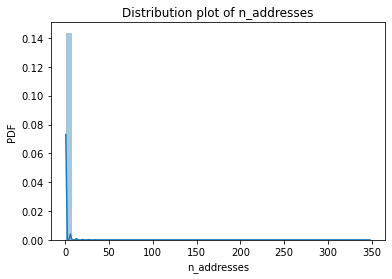

In [21]:
#plot to print distribution of n_addresses

plt.title('Distribution plot of n_addresses')
sns.distplot(n_addresses)
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

* We get an extremely skewed distribution, hence we will try to zoom-in for better inference

In [22]:
#Since this is an extremely skewed feature let's only visualize the 5th percentile points
fifth_percentile = np.percentile(n_addresses, 99)

n_addresses_fifthpercentile = np.array([element for element in n_addresses if element <= fifth_percentile])

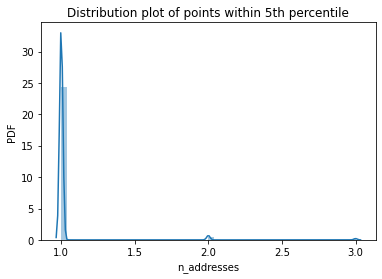

In [23]:
#checking points only within 5th percentile

plt.title('Distribution plot of points within 5th percentile')
sns.distplot(n_addresses_fifthpercentile)
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

* We see that most addresses are repeated only once and a small percentage of them are repeated twice.

####  Trying to fix skewness

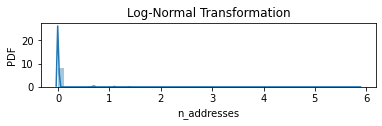

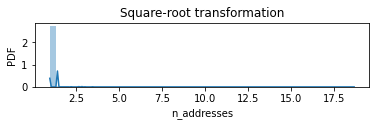

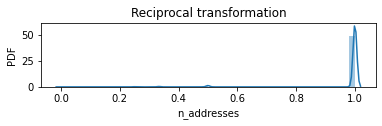

In [24]:
#Checking multiple transforms to see what works best for the feature

#Checking log-transform
plt.subplot(311)
plt.title('Log-Normal Transformation')
sns.distplot(np.log(n_addresses))
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

#Checking square-root transform
plt.subplot(312)
plt.title('Square-root transformation')
sns.distplot(np.sqrt(n_addresses))
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

#Checking reciprocal transform
plt.subplot(313)
plt.title('Reciprocal transformation')
sns.distplot(1/np.array(n_addresses))
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

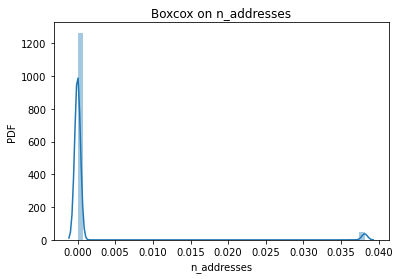

In [25]:
#Since none of the above seems to work, lets try boxcox

plt.title('Boxcox on n_addresses')
sns.distplot(boxcox(n_addresses)[0])
plt.xlabel('n_addresses')
plt.ylabel('PDF')
plt.show()

In [23]:
dict_n_address = dict(X_train['address'].value_counts())
#dict_n_address contains a dictionary of addresses and the number of times they appear in training set


n_address = boxcox(np.array(list(dict_n_address.values())))[0]
#Applying boxcox over all the number of times each address apears

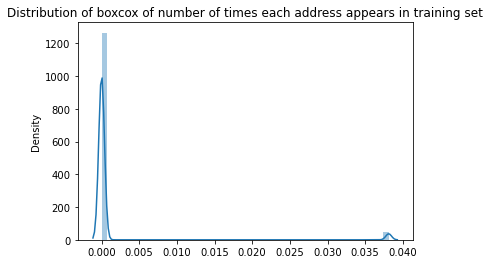

In [27]:
sns.distplot(n_address)
plt.title('Distribution of boxcox of number of times each address appears in training set')
plt.show()

In [35]:
len(n_address) == len(np.array(list(dict_n_address.values()))) #just a sanity check

True

In [34]:
for index, key in tqdm(enumerate(dict_n_address.keys())):
    #We are updating the dictionary with number of times each address appears with
    #the boxcox transformation applied to fix the skewness
    updated = {key: n_address[index]}
    dict_n_address.update(updated)

In [30]:
pd.Series(list(dict_n_address.values())).value_counts()

0.000000    2046548
0.038124      43000
0.038124      19373
0.038124      12829
dtype: int64

#### Constructing new feature: n_address_feature
* The feature contains the number of times the address has been seen in the training set (boxcox transformation applied)

In [ ]:
n_address_feature_train = np.array([])

for index, row in tqdm(X_train.iterrows(), total=X_train.shape[0]):
    #We are getting a list of the new values
    #For each address in the training set we are appending its corresponding boxcox'd
    #number of times its appeared in training set

    n_address_i = dict_n_address.get(X_train.loc[index]['address']) 
    n_address_feature_train = np.append(n_address_feature_train, n_address_i)

In [ ]:
n_address_feature_test = np.array([])
min_dict_n_address = min(list(dict_n_address.values()))

for index, row in tqdm(X_test.iterrows(), total=X_test.shape[0]):
    try:
        #we do the same as above

        n_address_i = dict_n_address[X_test.loc[index]['address']]
    except KeyError:
        #KeyError arises when the addreses in training set has not been seen before (i.e cold start)
        #For this, we assign the minimum value to it

        n_address_i = min_dict_n_address #Addressing cold start
    n_address_feature_test = np.append(n_address_feature_test, n_address_i)

### 2.3.2 Day

#### Looking at its distribution

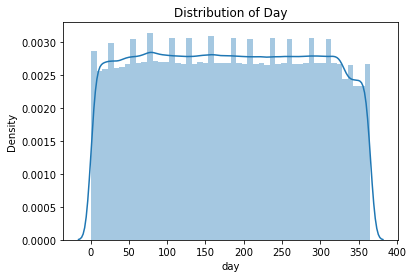

In [33]:
sns.distplot(X_train['day'])
plt.title('Distribution of Day')
plt.show()

#### Constructing new feature: quarter_number
* Feature indicates which quarter of the year the day number belongs to

In [ ]:
def get_quarter(day):
    if day <= 91:
        #First 3 months, so we return quarter number = 1
        return 1
    elif day <= 91 * 2:
        #Next 3 months, quarter number = 2
        return 2
    elif day <= 91 * 3:
        #Next 3 months, quarter number = 3
        return 3
    else:
        #Last 4 months, quarter nubmer = 4
        return 4

quarter_number_feature_train = np.array([])
day_train = X_train['day']

for day in tqdm(day_train):
    #For each day, we append its correspoding quarter number

    quarter_number_feature_train = np.append(quarter_number_feature_train, get_quarter(day))

In [ ]:
quarter_number_feature_test = np.array([])
day_test = X_test['day']

for day in tqdm(day_test):
    #Doing the same for test set

    quarter_number_feature_test = np.append(quarter_number_feature_test, get_quarter(day))

#### Constructing new feature: is_close_to_holiday
* Feature indicates if the day number was close to a major public holiday in America

In [ ]:
'''
Major Holidays in America:

New Year’s Day, January 1.
Birthday of Martin Luther King, Jr., the third Monday in January.
Washington’s Birthday, the third Monday in February.
Memorial Day, the last Monday in May.
Independence Day, July 4.
Labor Day, the first Monday in September.
Columbus Day, the second Monday in October.
Veterans Day, November 11.
Thanksgiving Day, the fourth Thursday in November.
Christmas Day, December 25.
'''

#Let's convert all the above days to day_number

public_holidays = [
    1, #New Year’s Day, January 1
    15, #Birthday of Martin Luther King, Jr, 15 January
    53, #Washington's birthday February 22
    151, #Memorial day, May 31
    185, #Independence day, July 4
    121, #Labor day, May 1
    285, #Columbus day, October 12
    315, #Veteran's day, November 11
    330, #Thanksgiving day, November 26
    360, #Christmas day, December 25
]

In [ ]:
def is_close(holiday, day):
    #if the day is within 1 week leading upto the holiday or after the holiday return True
    if np.abs(holiday - day) > 7:
        return 0
    return 1


is_close_to_holiday_train = np.array([], dtype=int)
for index, day in tqdm(enumerate(X_train['day'])):
    #For each day, we check if its close to any major holiday; if so, we append 1 else 0

    is_close_to_holiday_train = np.append(is_close_to_holiday_train, any([is_close(holiday, day) for holiday in public_holidays]))

In [ ]:
is_close_to_holiday_test = np.array([], dtype=int)
for index, day in tqdm(enumerate(X_test['day'])):
    #Same as above but for test set

    is_close_to_holiday_test = np.append(is_close_to_holiday_test, any([is_close(holiday, day) for holiday in public_holidays]))

#### Constructing a new feature: day_of_the_week
* Feature indicates the number of the weekday (for eg: 0 for Monday and 6 for Sunday). The hypothesis is that the day of the week might correlate with the nature of the transaction

In [ ]:
def get_day_number(first_day, day_i):
    #return day number (0 for monday, 6 for sunday) for day_i
    return (first_day + day_i - 1) % 7

day_of_week_train = np.array([])
for index, row in tqdm(X_train.iterrows()):
    #For each data-point, we consider its year and day and calculate what day of the week (Monday, Tuesday, etc)
    #it was when the transaction happened

    #datetime.datetime(year, 1, 1).weekday() returns the first day of the year in the year = year
    #using this information, we can calculate the present day

    year_i, day_i = row['year'], row['day']
    day_of_week_train = np.append(day_of_week_train, get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

In [ ]:
day_of_week_test = np.array([])
for index, row in tqdm(X_test.iterrows()):
    #same as above but for test set

    year_i, day_i = row['year'], row['day']
    day_of_week_test = np.append(day_of_week_test, get_day_number(datetime.datetime(year_i, 1, 1).weekday(), day_i))

### 2.3.3 Length

#### Looking at its distribution

[]

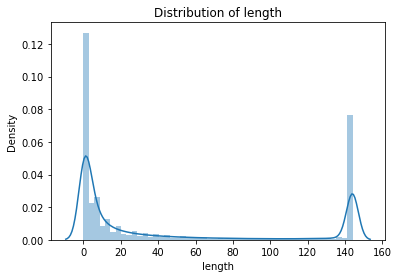

In [42]:
sns.distplot(X_train['length'])
plt.title('Distribution of length')
plt.plot()

#### Constructing new feature: gaussian_length
* Feature tries to fix the skewness of the length variable. This is done by applying complex functions over the length feature and then performing a boxcox operation on it

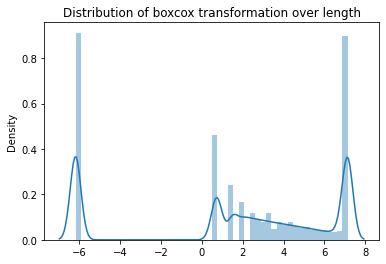

In [43]:
sns.distplot(boxcox(np.array(X_train['length']) + 1e-6)[0])
plt.title('Distribution of boxcox transformation over length')
plt.show()

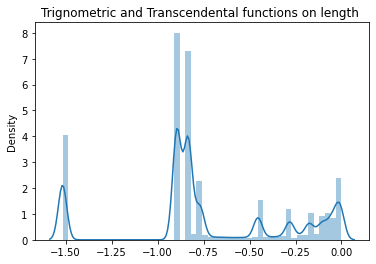

In [44]:
#We can see a sort of 'cyclic' waveform in the above graph. it appears that we have an
#alternating pattern of high and low values. maybe sin transform might help?

sns.distplot(boxcox((np.sin(np.log(np.sqrt(np.array(X_train['length']) + 1e-6)))) ** 2)[0])
plt.title('Trignometric and Transcendental functions on length ')
plt.show()

* These transformations make the distribution more gaussian and thus, will help during modelling

In [ ]:
#constructing the feature

gaussian_length_train = boxcox((np.sin(np.log(np.sqrt(np.array(X_train['length']) + 1e-6)))) ** 2)[0]
gaussian_length_test = boxcox((np.sin(np.log(np.sqrt(np.array(X_test['length']) + 1e-6)))) ** 2)[0]

### 2.3.4 Weight

#### Looking at its distribution

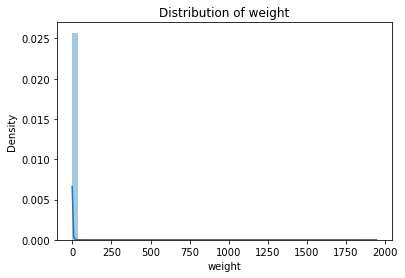

In [46]:
sns.distplot(X_train['weight'])
plt.title('Distribution of weight')
plt.show()

* Weight is also an extremely skewed-feature, thus we will try to fix the skewness

#### Constructing new feature: gaussian_weight
* Feature corrects for the skewedness in weight

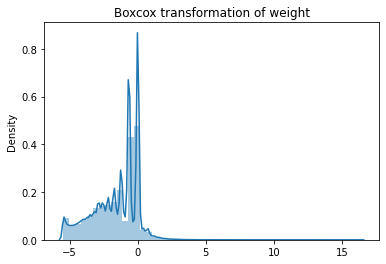

In [47]:
sns.distplot(boxcox(np.array(X_train['weight'], dtype=np.longdouble))[0])
plt.title('Boxcox transformation of weight')
plt.show()

* Box-cox transformation over weight gives us a much more normal distribution

In [ ]:
#Apply boxcox transform on weight
gaussian_weight_train = np.array(boxcox(np.array(X_train['weight'],  dtype=np.longdouble))[0])
#for test set as well
gaussian_weight_test = np.array(boxcox(np.array(X_test['weight'],  dtype=np.longdouble))[0])

### 2.3.5 Count

#### Looking at its distribution

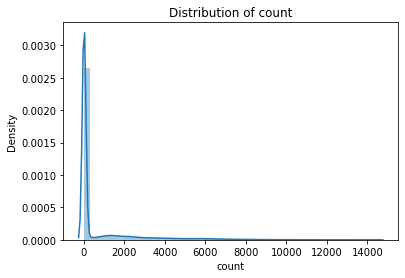

In [49]:
sns.distplot(X_train['count'])
plt.title('Distribution of count')
plt.show()

* Again, we see an extremely-skewed log-normal distribution for the Count feature

#### Performing log-transformation to fix skewedness

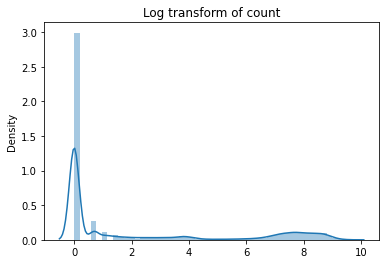

In [50]:
sns.distplot(np.log(np.array(X_train['count']) + 1e-6))
plt.title('Log transform of count')
plt.show()

* While performing log to get a normal-distribution still gives us a skewed distribution, it is certainly better than the vanilla feature

In [ ]:
#apply log-transform on training

log_count_train = np.log(np.array(X_train['count']) + 1e-6)

#log transform for test

log_count_test = np.log(np.array(X_test['count']) + 1e-6)

### 2.3.6 Looped

#### Looking at its distribution

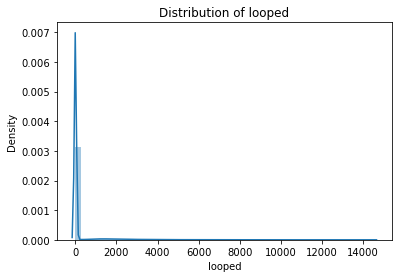

In [52]:
sns.distplot(X_train['looped'])
plt.title('Distribution of looped')
plt.show()

* Again, we find an extremely skewed log-normal distribution for the looped feature

#### Performing sigmoid operation to fix skewedness

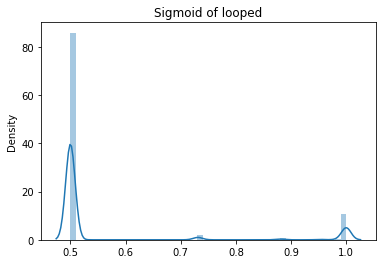

In [53]:
def sigmoid(x):
    #returns the logistic function of x
    
    return 1 / (1 + np.exp(-x))

sns.distplot(sigmoid(np.array(X_train['looped'])))
plt.title('Sigmoid of looped')
plt.show()

* Sigmoidal transformation gives the models a better distribution to work with

In [ ]:
#Applying logistic function on each element of looped

sigmoid_looped_train = sigmoid(np.array(X_train['looped']))
#Same for test

sigmoid_looped_test = sigmoid(np.array(X_test['looped']))

### 2.3.7 Neighbors

#### Looking at its distribution

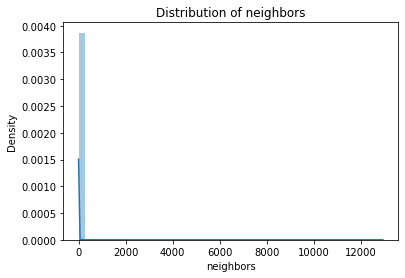

In [55]:
sns.distplot(X_train['neighbors'])
plt.title('Distribution of neighbors')
plt.show()

* Again, we see an extremely skewed distribution for Neighbors feature

#### Constructing a new feature: gaussian_neighbors
* Feature tries to account for the extreme skewedness of neighbors by applying boxcox transformation

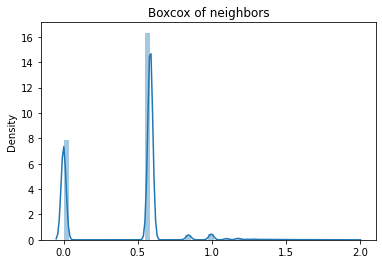

In [56]:
sns.distplot(boxcox(np.array(X_train['neighbors']) + 1e-6)[0])
plt.title('Boxcox of neighbors')
plt.show()

* Boxcox transformation over Neighbors gives us a slighly more gaussian distribution

In [ ]:
#Applying boxcox transform for neighbors

gaussian_neighbors_train = boxcox(np.array(X_train['neighbors']) + 1e-6)[0]
#Same for test

gaussian_neighbors_test = boxcox(np.array(X_test['neighbors']) + 1e-6)[0]

### 2.3.8 Income

#### Looking at its distribution

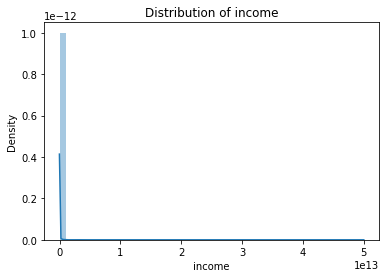

In [58]:
sns.distplot(X_train['income'])
plt.title('Distribution of income')
plt.show()

* Again, we see a very skewed distribution for the Income feature

#### Constructing new feature: gaussian_income
* Feature tries to account for the extreme skewedness of income by applying boxcox transformation

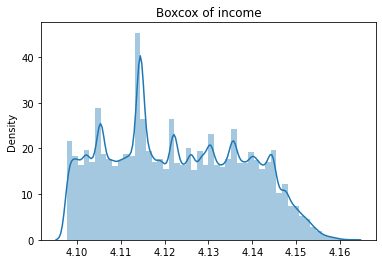

In [59]:
sns.distplot(boxcox(np.array(X_train['income']) + 1e-6)[0])
plt.title('Boxcox of income')
plt.show()

* Boxcox transformation over Income gives us a psuedo-gaussian distribution

In [ ]:
#Applying boxcox on income

gaussian_income_train = boxcox(np.array(X_train['income']) + 1e-6)[0]
gaussian_income_test = boxcox(np.array(X_test['income']) + 1e-6)[0]

### 2.4 Constructing complex features

### 2.4.1 Interaction features

#### 2.4.1.1 Between length and weight

In [ ]:
median_length = np.median(X_train['length'])
median_weight = np.median(X_train['weight'])

def get_length_weight(length_i, weight_i):
    #If length and weight are greater than the median, we will return 0
    #If just length is greater than the median we return 1
    #return 2 if length is lesser than median
    
    if length_i > median_length:
        if weight_i > median_weight:
            return 0
        else:
            return 1
    return 2

#Constructing the interaction feature for train

interaction_length_weight_train = np.array([])
for index, row in tqdm(X_train.iterrows(), total=X_train.shape[0]):
    interaction_length_weight_train = np.append(interaction_length_weight_train, get_length_weight(row['length'], row['weight']))

In [ ]:
#Same for test

interaction_length_weight_test = np.array([])
for index, row in tqdm(X_test.iterrows(), total=X_test.shape[0]):
    interaction_length_weight_test = np.append(interaction_length_weight_test, get_length_weight(row['length'], row['weight']))

#### 2.4.1.2 Between log-count and gaussian-income

In [ ]:
median_count = np.median(log_count_train)
median_income = np.median(gaussian_income_train)

def get_count_income(log_count_i, gaussian_income_i):
    #Return 0 if both log_count and gaussian_income are greater than their medians
    #return 1 if just log_count is
    #return 2 if log count is lesser than median
    
    if log_count_i > median_count:
        if gaussian_income_i > median_income:
            return 0
        else:
            return 1
    return 2

#construct the interaction feature
    
interaction_count_income_train = np.array([])
for i in tqdm(range(len(log_count_train))):
    interaction_count_income_train = np.append(interaction_count_income_train, get_count_income(log_count_train[i], gaussian_income_train[i]))

In [ ]:
#Same for test

interaction_count_income_test = np.array([])
for i in tqdm(range(len(log_count_test))):
    interaction_count_income_test = np.append(interaction_count_income_test, get_count_income(log_count_test[i], gaussian_income_test[i]))

### 2.5 Loading all features into a dataframe

#### 2.5.1 Adding features to original dataframe

In [11]:
#training

#Adding the features

X_train['n_address'] = n_address_feature_train #1
X_train['day_of_week'] = day_of_week_train #2
X_train['is_close_to_holiday'] = is_close_to_holiday_train #3
X_train['quarter_number'] = quarter_number_feature_train #4
X_train['gaussian_income'] = gaussian_income_train #5
X_train['gaussian_neighbors'] = gaussian_neighbors_train #6
X_train['gaussian_weight'] = gaussian_weight_train #7
X_train['gaussian_length'] = gaussian_length_train #8
X_train['log_count'] = log_count_train #9
X_train['sigmoid_looped'] = sigmoid_looped_train #10
X_train['interaction_count_income'] = interaction_count_income_train #11
X_train['interaction_length_weight'] = interaction_length_weight_train #12

In [68]:
X_train.head()

,address,year,day,length,weight,count,looped,neighbors,income,n_address,...,is_close_to_holiday,quarter_number,gaussian_income,gaussian_neighbors,gaussian_weight,gaussian_length,log_count,sigmoid_looped,interaction_count_income,interaction_length_weight
2264511,366ZrW8BbPeK21L7bwTJkzKqEfKJceJpKm,2017,43,0,0.500000,1,0,2,31515644.0,0.0,...,0,1.0,4.098487,5.841690e-01,-0.651137,-0.895193,9.999995e-07,0.5,2.0,2.0
1289376,1Nyy3jRxjmt9dCWPe5LvnSZhArnSfjAykR,2014,163,4,0.040000,1,0,2,100000000.0,0.0,...,0,2.0,4.114446,5.841690e-01,-2.434900,-0.769382,9.999995e-07,0.5,2.0,2.0
1046802,1B9zENZjbkFxwdjHSmAyqXrPq5FLb9vDmZ,2013,286,2,0.500000,1,0,1,81050000.0,0.0,...,1,4.0,4.111862,9.999992e-07,-0.651137,-1.517133,9.999995e-07,0.5,2.0,2.0
2335966,35hfQ92WkncKrupG9NVtSmScvKXXkBfnPD,2017,115,92,1.016858,72,0,2,100030000.0,0.0,...,1,2.0,4.114450,5.841690e-01,0.016743,-0.475286,4.276666e+00,0.5,1.0,0.0
1214724,1Bmm4KkZuzdzEjKtVmtTVyQoVKEE1J4wmz,2014,89,144,0.028767,1189,1187,4,184953990.0,0.0,...,0,1.0,4.121303,9.948198e-01,-2.612813,-0.835022,7.080868e+00,1.0,1.0,1.0


In [14]:
#testing

#Adding the features

X_test['n_address'] = n_address_feature_test #1
X_test['day_of_week'] = day_of_week_test #2
X_test['is_close_to_holiday'] = is_close_to_holiday_test #3
X_test['quarter_number'] = quarter_number_feature_test #4
X_test['gaussian_income'] = gaussian_income_test #5
X_test['gaussian_neighbors'] = gaussian_neighbors_test #6
X_test['gaussian_weight'] = gaussian_weight_test #7
X_test['gaussian_length'] = gaussian_length_test #8
X_test['log_count'] = log_count_test #9
X_test['sigmoid_looped'] = sigmoid_looped_test #10
X_test['interaction_count_income'] = interaction_count_income_test #11
X_test['interaction_length_weight'] = interaction_length_weight_test #12

In [15]:
X_test.head()

,address,year,day,length,weight,count,looped,neighbors,income,n_address,...,is_close_to_holiday,quarter_number,gaussian_income,gaussian_neighbors,gaussian_weight,gaussian_length,log_count,sigmoid_looped,interaction_count_income,interaction_length_weight
428885,18z5kGrm7e3NNq9WXjcKbTCfpEvsBrGsfP,2012,33,4,0.019033,71,0,1,3.020000e+08,0.000000,...,0,1.0,4.143602,9.999992e-07,-2.822421,-0.769659,4.262680e+00,0.5,0.0,2.0
1819947,1EDjBMxZec3q9PqHyoM6hZDPVtDwRDfCe,2015,329,144,0.009070,3897,0,2,1.000000e+08,0.038124,...,1,4.0,4.131723,5.842852e-01,-3.159500,-0.835351,8.267962e+00,0.5,0.0,1.0
739086,115gn63LBwn4qMcex3dvr8RVbSisyDW1ji,2012,343,142,0.165386,1609,1609,4,2.566676e+09,0.000000,...,0,4.0,4.159332,9.951913e-01,-1.534421,-0.822532,7.383368e+00,1.0,0.0,1.0
172467,1NWuBnXkQqHJb8SahQNtDP4a9eLAf4ZPXx,2011,141,10,0.130682,23,0,1,2.180000e+08,0.038124,...,0,2.0,4.140419,9.999992e-07,-1.700557,-0.175795,3.135494e+00,0.5,0.0,1.0
2691839,1HM4s2JFbhkqDWBMhQFW6NSMGZVK2vgvdE,2018,106,0,1.000000,1,0,2,3.227901e+08,0.000000,...,0,2.0,4.144222,5.842852e-01,0.000000,-0.895575,9.999995e-07,0.5,2.0,2.0


### 2.6 Making data ready for modelling

#### 2.6.1 Distance based models

In [ ]:
'''
'address' : To be dropped
'year' : To be standardized
'day' : To be standardized
'length' : To be standardized
'weight' : To be standardized 
'count' : To be standardized
'looped' : To be standardized
'neighbors' : To be standardized
'income' : To be standardized
'n_address' : To be standardized
'day_of_week' : To be One hot encoded
'is_close_to_holiday', : Binary feature. To be left as is 
'quarter_number' : To be One hot encoded
'gaussian_income' : To be standardized
'gaussian_neighbors' : To be standardized
'gaussian_weight' : To be standardized
'gaussian_length' : To be standardized
'log_count' : To be standardized
'sigmoid_looped' : To be standardized
'interaction_count_income' : To be One Hot encoded
'interaction_length_weight' : To be One hot encoded
'''
pass

In [16]:
#Scale the data

col_names_standardize = [
    'year',
    'day',
    'length',
    'weight',
    'count',
    'looped',
    'neighbors',
    'income',
    'n_address',
    'gaussian_income',
    'gaussian_neighbors',
    'gaussian_weight',
    'gaussian_length',
    'log_count',
    'sigmoid_looped'
]

#encode the data

col_names_encode = [
    'day_of_week',
    'quarter_number',
    'interaction_count_income',
    'interaction_length_weight'
]

transformer = ColumnTransformer([
    ('standardize', StandardScaler(), col_names_standardize),
    ('encode', OneHotEncoder(), col_names_encode)
], remainder = 'passthrough')

transformer.fit(X_train.drop(['address'], axis=1))

X_train_distance = transformer.transform(X_train.drop(['address'], axis=1))
X_test_distance = transformer.transform(X_test.drop(['address'], axis=1))

In [17]:
pd.DataFrame(X_train_distance).head()

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,1.118440,-1.331324,-0.763299,-0.012475,-0.426614,-0.246761,-0.011472,-0.027877,-0.374357,-1.630327,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,-0.210551,-0.177655,-0.695495,-0.134889,-0.426614,-0.246761,-0.011472,-0.027444,-0.374357,-0.565675,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.653547,1.004857,-0.729397,-0.012475,-0.426614,-0.246761,-0.067468,-0.027564,-0.374357,-0.738092,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
3,1.118440,-0.639122,0.796201,0.125070,-0.384628,-0.246761,-0.011472,-0.027444,-0.374357,-0.565435,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,-0.210551,-0.889084,1.677657,-0.137879,0.275925,0.981263,0.100520,-0.026906,-0.374357,-0.108267,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [20]:
if input('Save training and testing along with labels?') == 'y':
    with open('13_2_DIST_X_train_y_train_X_test_y_test.pickle', 'wb') as save_file:
        pickle.dump([X_train_distance, y_train, X_test_distance, y_test], save_file)

Save training and testing along with labels?y


#### 2.6.2 Tree based models

In [74]:
'''
Don't need to perform standardization or encoding for tree based models
'''

"\nDon't need to perform standardization or encoding for tree based models\n"

In [75]:
X_train_tree, X_test_tree = X_train.drop(['address'], axis=1).to_numpy(), X_test.drop(['address'], axis=1).to_numpy()

In [76]:
pd.DataFrame(X_train_tree).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2017.0,43.0,0.0,0.500000,1.0,0.0,2.0,31515644.0,0.0,6.0,0.0,1.0,4.098487,5.841690e-01,-0.651137,-0.895193,9.999995e-07,0.5,2.0,2.0
1,2014.0,163.0,4.0,0.040000,1.0,0.0,2.0,100000000.0,0.0,3.0,0.0,2.0,4.114446,5.841690e-01,-2.434900,-0.769382,9.999995e-07,0.5,2.0,2.0
2,2013.0,286.0,2.0,0.500000,1.0,0.0,1.0,81050000.0,0.0,6.0,1.0,4.0,4.111862,9.999992e-07,-0.651137,-1.517133,9.999995e-07,0.5,2.0,2.0
3,2017.0,115.0,92.0,1.016858,72.0,0.0,2.0,100030000.0,0.0,1.0,1.0,2.0,4.114450,5.841690e-01,0.016743,-0.475286,4.276666e+00,0.5,1.0,0.0
4,2014.0,89.0,144.0,0.028767,1189.0,1187.0,4.0,184953990.0,0.0,6.0,0.0,1.0,4.121303,9.948198e-01,-2.612813,-0.835022,7.080868e+00,1.0,1.0,1.0


- combined_dataframes : For EDA
- distance_based_data : For distance based models
- tree_based_data : For tree based models

# 3.0 Uni-variate analysis
* Univariate analysis is the technique of comparing and analyzing the dependency of a single predictor and a response variable. The prefix "uni" means one, emphasizing the fact that the analysis only accounts for one variable's effect on a dependent variable

* In this section we will look at our features' Probabiliy Density Function (PDF) which gives us the relative likelihood of a random variable taking a value in a specific range.
* Ideally these PDF's should be normally distributed, meaning they should look like a bell curve because some of our models have naive assumptions of the data-set they operate on.
* For this reason, if they are not normally distributed, we will modify them by applying transformation functions to better suit our needs
* We will also plot PDF's of features whose datapoints belong to class 0 and 1 separately. This will help us see if there is any difference in the PDF's. If there is, our models perform better.

## 3.1 Data dictionary

### 3.1.1 Vanilla features

    1. address [String]: 
    - Stores the address of the bitcoin transaction.
    
    2. year [int]      :
    - Indicates the year in which the transaction has been done.
    
    3. day [int]       : 
    - Indicates day of the year.
    
    4. length [int]    : 
    - Length is designed to quantify mixing rounds on Bitcoin, where transactions receive and distribute                             similar amounts of coins in multiple rounds with newly created addresses to hide the coin origin.
    
    5. weight [float]  :
    - Weight quantifies the merge behavior (i.e., the transaction has more input addresses than output                               addresses), where coins in multiple addresses are each passed through a succession of merging                                   transactions and accumulated in a final address.
    
    6. count [int]     :
    - Similar to weight, the count feature is designed to quantify the merging pattern. However, the count                           feature represents information on the number of transactions, whereas the weight feature represents                             information on the amount of transaction.
    
    7. looped [int]    :
    - Loop is intended to count how many transaction i) split their coins; ii) move these coins in the                               network by using different paths and finally, and iii) merge them in a single address. Coins at this                           final address can then be sold and converted to fiat currency.
    
    8. neighbors [int] :
    - Indicates the number of neighbors a transcation had.
    
    9. income [int]    :
    - Income in terms of Satoshi amount where a Satoshi is the smallest unit of a bitcoin, equivalent to 100                         millionth of a bitcoin.

### 3.1.2 Engineered features

    1. n_address [int]:
    - Indicates number of times the unique address has been seen in training set.

    2. day_of_week [int]:
    - Indicates day number. For example, 0 for Monday and 6 for Sunday.

    3. is_close_to_holiday [Binary]:
    - Indicator variable. 1 if transaction has been made during a public holiday in America; 0 otherwise.

    4. quarter_number [int]:
    - Indicates the quarter (Q1, .. Q4) in which the transaction has been made

    5. gaussian_income [float]:
    - Gaussianized income

    6. gaussian_neighbors [float]:
    - Gaussianized neighbors

    7. gaussian_weight [float]:
    - Gaussianized weight

    8. gaussian_length [float]:
    - Gaussianized length

    9. log_count [float]:
    - Log transformed count

    10. sigmoid_looped [float]:
    - Logistic function of looped

    11. interaction_count_income [float]:
    - Interaction feature between count and income

    12. interaction_length_weight [float]:
    - Interaction feature between length and weight

### 3.2 Basic stats

In [77]:
print('Training set has {} rows and {} columns'.format(X_train.shape[0], X_train.shape[1]))

Training set has 2333357 rows and 21 columns


In [78]:
print('Training set has {} points that belong to postitive class (Malware) and {} points that belong to negative class (Clean)'.format(
    sum(y_train),
    len(y_train) - sum(y_train)
))

Training set has 33130.0 points that belong to postitive class (Malware) and 2300227.0 points that belong to negative class (Clean)


In [79]:
print('Testing set has {} rows and {} columns'.format(X_test.shape[0], X_test.shape[1]))

Testing set has 583340 rows and 21 columns


In [80]:
print('Testing set has {} points that belong to postitive class (Malware) and {} points that belong to negative class (Clean)'.format(
    sum(y_test),
    len(y_test) - sum(y_test)
))

Testing set has 8283.0 points that belong to postitive class (Malware) and 575057.0 points that belong to negative class (Clean)


In [81]:
print('Percentage of positive class data-points: {}%'.format((sum(y_train)/(len(y_train)) * 100)))

Percentage of positive class data-points: 1.4198427415950496%


- Since there is a high imbalance in our data, lets undersample datapoints from negative class for the rest of the anaylsis.

In [82]:
#Undersampling negative class

undersampled_df = pd.DataFrame([], columns = X_train.columns)
index = 0

for index_df, row in tqdm(X_train.iterrows()):
    if y_train[index] == 1:
        #skip if positive class
        index += 1
        continue

    if np.random.uniform(0, 1) <= 0.015:
        #We are getting data-points with a probability of 1.5%
        undersampled_df = undersampled_df.append(row, ignore_index=True)
    index += 1

In [83]:
#taking a sub-df of all the positive class datapoints for comparison

positive_df = pd.DataFrame([], columns = X_train.columns)
index = 0

for index_df, row in tqdm(X_train.iterrows()):
    if y_train[index] == 0:
        index += 1
        continue

    positive_df = positive_df.append(row, ignore_index=True)
    index += 1

In [84]:
undersampled_df.head()

,address,year,day,length,weight,count,looped,neighbors,income,n_address,...,is_close_to_holiday,quarter_number,gaussian_income,gaussian_neighbors,gaussian_weight,gaussian_length,log_count,sigmoid_looped,interaction_count_income,interaction_length_weight
0,17dQ4EExXeSLh7PBTmRz6MWimHHzggJArx,2011,241,64,1.907349e-06,1,0,2,1.979375e+09,0.0,...,0,3.0,4.140005,0.584169,-4.987797,-0.258325,9.999995e-07,0.5,2.0,1.0
1,12PQ6TfwTYfwMo14QDfMnax14aW2rVScbW,2012,143,142,7.039553e-14,1020,0,2,1.321376e+08,0.0,...,0,2.0,4.117679,0.584169,-5.462860,-0.822214,6.927558e+00,0.5,1.0,1.0
2,1ERwwv8Y1AATPsqvCGpiUi4MAHNe9f6E2m,2014,348,144,4.886916e-02,1614,0,2,1.015800e+08,0.0,...,0,4.0,4.114634,0.584169,-2.321481,-0.835022,7.386471e+00,0.5,1.0,1.0
3,3MhZoUaob7j2Z2vhBakrd1X1F1X1MWqiaa,2017,12,16,6.666667e-01,2,0,2,1.063288e+08,0.0,...,1,1.0,4.115177,0.584169,-0.390841,-0.034032,6.931477e-01,0.5,1.0,0.0
4,3EwJNBVeaBZxnBkbq6UMAvjpFQDW9W14NR,2018,159,0,5.000000e-01,1,0,2,1.465271e+08,0.0,...,0,2.0,4.118824,0.584169,-0.651137,-0.895193,9.999995e-07,0.5,2.0,2.0


In [85]:
print('Undersampled dataframe has {} rows and {} columns'.format(undersampled_df.shape[0], undersampled_df.shape[1]))

Undersampled dataframe has 34511 rows and 21 columns


### 3.3 n_address
* Feature indicates the number of times addresss has appeared in training data.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

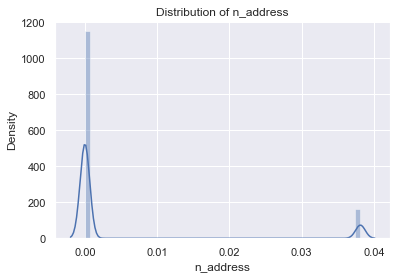

In [86]:
#Distribution of n_address

sns.set_theme('notebook')
sns.distplot(X_train['n_address'])
plt.title('Distribution of n_address')
plt.show()

[]

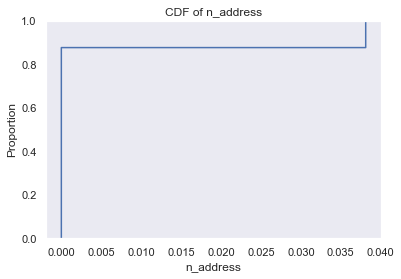

In [87]:
#plotting its cdf

sns.ecdfplot(X_train, x='n_address')
plt.title('CDF of n_address')
plt.grid()
plt.plot()

#### White vs Ransomware

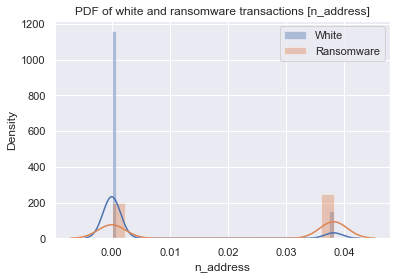

In [88]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['n_address'], label = 'White')
sns.distplot(positive_df['n_address'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [n_address]')
plt.show()

* We notice that there is quite a lot of separability between the two-classes in their respective PDFs

### 3.4 year
* Feature indicates what year the transaction had taken place in.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

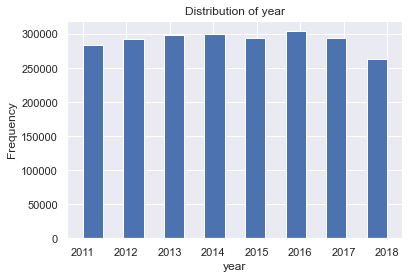

In [89]:
#Displaying histogram of year feature

X_train['year'].plot(kind = 'hist', bins=15)
plt.xlabel('year')
plt.title('Distribution of year')
plt.show()

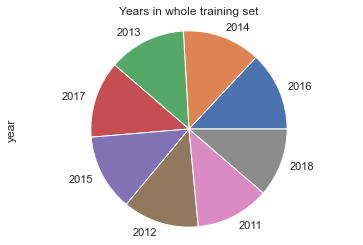

In [90]:
#displaying pie-chart

X_train['year'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Years in whole training set')
plt.show()

* We see that the the Years are uniformly distributed

#### PDF of white vs ransomware

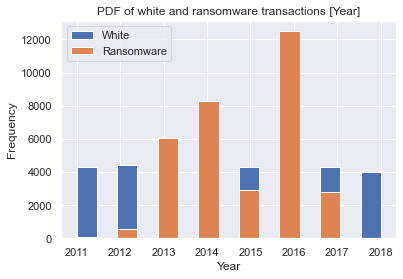

In [91]:
#checking to see if the year in which the transaction has been made has any correlation with the transaction

undersampled_df['year'].plot(kind = 'hist', bins=15, label='White')
positive_df['year'].plot(kind = 'hist', bins=15, label='Ransomware')
plt.xlabel('year')
plt.title('PDF of white and ransomware transactions [Year]')
plt.xlabel('Year')
plt.legend()
plt.show()

* Transactions made in 2011, 2012 and 2018 are far more likely to be white rather than ransomware

### 3.5 Day
* Feature indicates the day number of the year on which the transaction took place.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

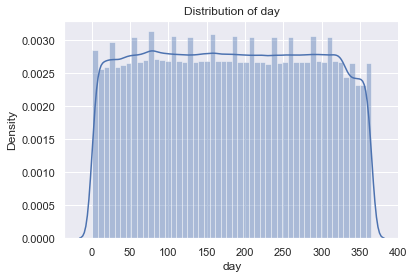

In [92]:
#plotting pdf

sns.distplot(X_train['day'])
plt.title('Distribution of day')
plt.show()

* Days looks to be pretty uniformly distributed

#### PDF of white vs ransomware

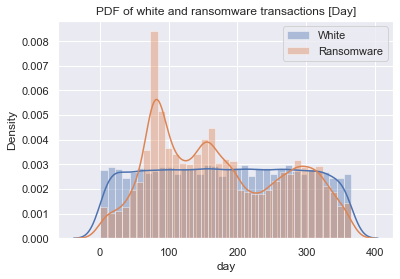

In [93]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['day'], label = 'White')
sns.distplot(positive_df['day'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Day]')
plt.show()

* The two functions seem to be distinguishable on certain days. For example, on day 95 the transactions are far more likely to be white rather than ransomware

### 3.6 Length
* Feature indicates the mixing rounds on Bitcoin, where transactions receive and distribute similar amounts of coins in multiple rounds with newly created addresses to hide the coin origin.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

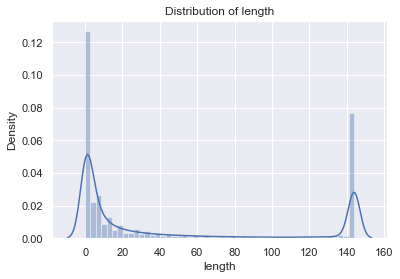

In [94]:
#plotting pdf

sns.distplot(X_train['length'])
plt.title('Distribution of length')
plt.show()

#### PDF of white vs ransomware

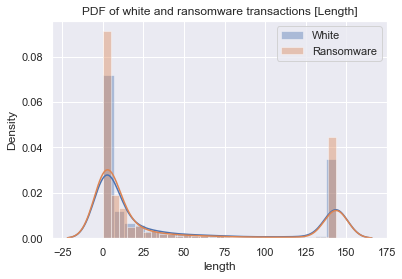

In [95]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['length'], label = 'White')
sns.distplot(positive_df['length'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Length]')
plt.show()

* The distributions look almost indistinguishable

### 3.7 Weight
* Feature indicates the merge behavior
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

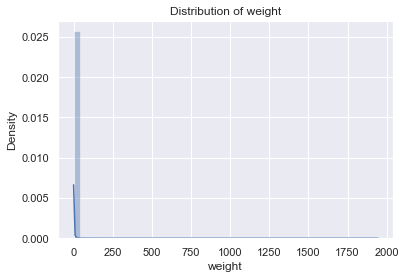

In [96]:
#plotting pdf

sns.distplot(X_train['weight'])
plt.title('Distribution of weight')
plt.show()

#### PDF of white vs ransomware

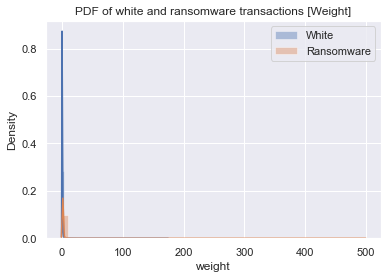

In [97]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['weight'], label = 'White')
sns.distplot(positive_df['weight'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Weight]')
plt.show()

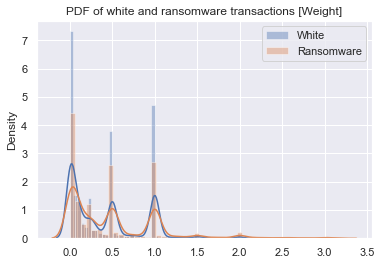

In [98]:
#Printing pdf's for 98th percentile to zoom in

sns.distplot([i for i in undersampled_df['weight'] if i < np.percentile(undersampled_df['weight'], 98)], label = 'White')
sns.distplot([i for i in positive_df['weight'] if i < np.percentile(positive_df['weight'], 98)], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Weight]')
plt.show()

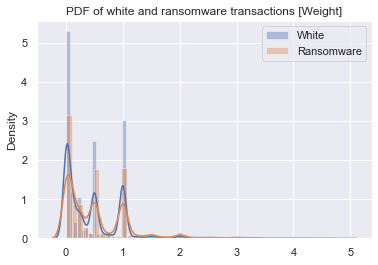

In [99]:
#printing PDF for 99th percentile to zoom in further

sns.distplot([i for i in undersampled_df['weight'] if i < np.percentile(undersampled_df['weight'], 99)], label = 'White')
sns.distplot([i for i in positive_df['weight'] if i < np.percentile(positive_df['weight'], 99)], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [Weight]')
plt.show()

* It seems like probability of a transction being ransomware is higher when at higher densities at peeks in the PDF of weight

### 3.8 Count
* Feature indicates the merging pattern.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

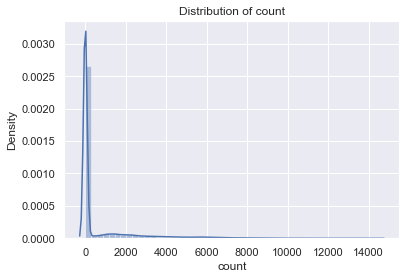

In [100]:
#plotting pdf

sns.distplot(X_train['count'])
plt.title('Distribution of count')
plt.show()

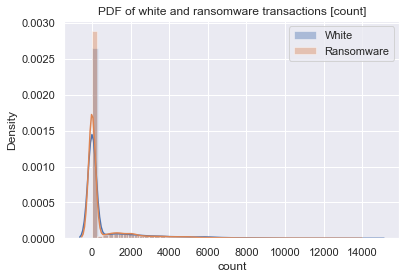

In [101]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['count'], label = 'White')
sns.distplot(positive_df['count'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [count]')
plt.show()

* We notice very little separability between the two-classes

[]

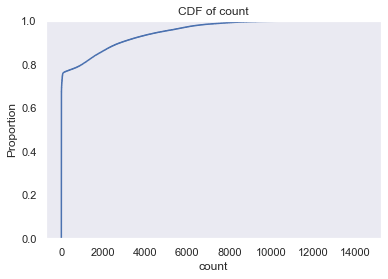

In [103]:
sns.ecdfplot(X_train, x='count')
plt.title('CDF of count')
plt.grid()
plt.plot()

### 3.9 Looped
* Feature indicates  how many transaction i) split their coins; ii) move these coins in the network by using different paths and finally, and iii) merge them in a single address.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribtuion

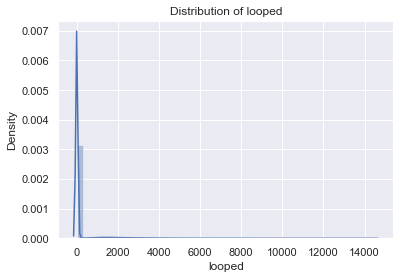

In [104]:
#plotting pdf

sns.distplot(X_train['looped'])
plt.title('Distribution of looped')
plt.show()

#### PDFs of white vs ransomware

[]

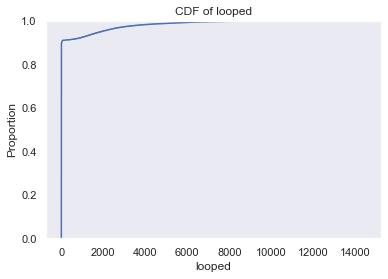

In [105]:
sns.ecdfplot(X_train, x='looped')
plt.title('CDF of looped')
plt.grid()
plt.plot()

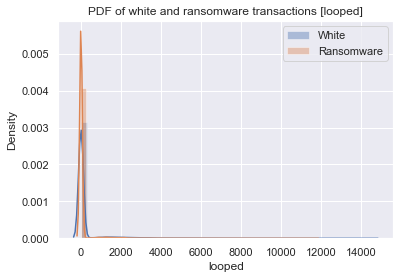

In [106]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['looped'], label = 'White')
sns.distplot(positive_df['looped'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [looped]')
plt.show()

* We notice quite a lot of separability when the value of looped is around '0'. However, above 500, there appears to be no separability.

### 3.10 Neighbors
* Feature indicates number of neighbours a transaction had.
* Now let us look at its distribution and how it affects the target variable.

#### Looking at its distribution

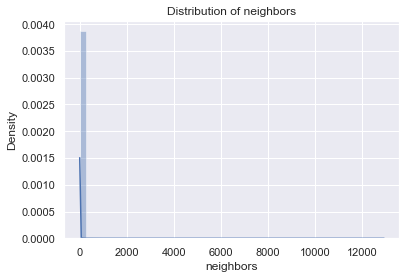

In [107]:
#Distribution of neighbors

sns.distplot(X_train['neighbors'])
plt.title('Distribution of neighbors')
plt.show()

[]

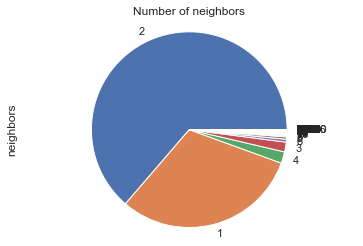

In [108]:
X_train.neighbors.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Number of neighbors')
plt.plot()

* It seems that most data-points have 2 neighbors

[]

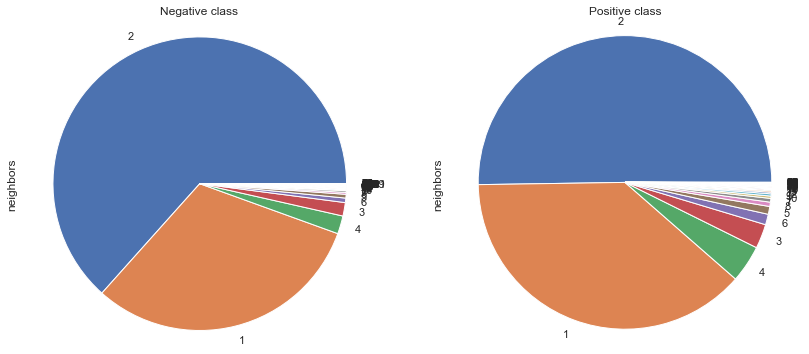

In [109]:
plt.figure(figsize=(14, 6))

#plotting piechart of negative class
plt.subplot(121)
undersampled_df.neighbors.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Negative class')
plt.plot()


plt.subplot(122)
positive_df.neighbors.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Positive class')
plt.plot()

* It's clear that both positive classes and negative classes follow considerably different distributions

### 3.11 Income
* Let us see how the income generated changes with the target variable

#### Looking at its distribution

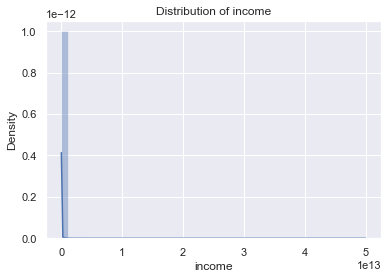

In [110]:
#plotting pdf

sns.distplot(X_train['income'])
plt.title('Distribution of income')
plt.show()

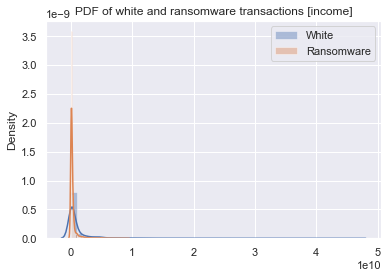

In [111]:
#plotting pdfs of white and ransomware

sns.distplot(np.array([i for i in undersampled_df['income'] if i < np.percentile(undersampled_df.income, 99)]), label = 'White')
sns.distplot(np.array([i for i in positive_df['income'] if i < np.percentile(positive_df.income, 99)]), label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [income]')
plt.show()

* It's evident that ransomware transactions usually contain a higher amount of income

### 3.12 Day of the week
* Let us see how the target variable changes with the day of week

#### Looking at its distribution

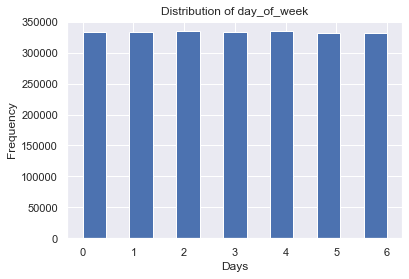

In [112]:
#Displaying histogram of day_of_week feature

X_train['day_of_week'].plot(kind = 'hist', bins=13)
plt.xlabel('day_of_week')
plt.title('Distribution of day_of_week')
plt.xlabel('Days')
plt.show()

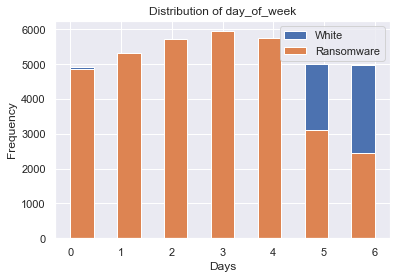

In [113]:
#Displaying histogram of day_of_week feature

undersampled_df['day_of_week'].plot(kind = 'hist', bins=13, label='White')
positive_df['day_of_week'].plot(kind = 'hist', bins=13, label='Ransomware')
plt.xlabel('day_of_week')
plt.title('Distribution of day_of_week')
plt.xlabel('Days')
plt.legend()
plt.show()

* It seems that transactions done over the week are far more likely to be white than ransomware

### 3.13 Is close to holiday
* Let us see if transactions are more (or less) likely to be fraudulent during the holidays

#### Looking at its distribution

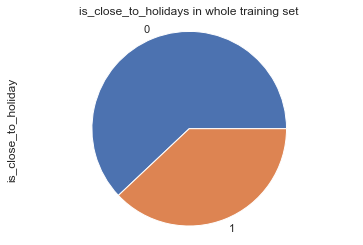

In [114]:
#displaying pie-chart

X_train['is_close_to_holiday'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('is_close_to_holidays in whole training set')
plt.show()

[]

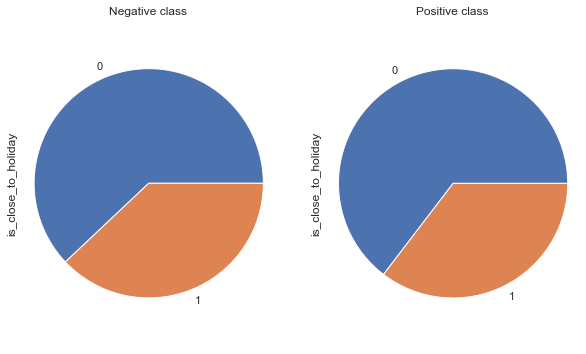

In [115]:
plt.figure(figsize=(10, 6))

#plotting piechart of negative class
plt.subplot(121)
undersampled_df.is_close_to_holiday.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Negative class')
plt.plot()


plt.subplot(122)
positive_df.is_close_to_holiday.value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('Positive class')
plt.plot()

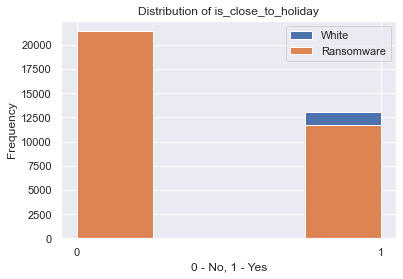

In [116]:
#Displaying histogram of is_close_to_holiday feature

undersampled_df['is_close_to_holiday'].plot(kind = 'hist', bins=4, label='White')
positive_df['is_close_to_holiday'].plot(kind = 'hist', bins=4, label='Ransomware')
plt.xlabel('is_close_to_holiday')
plt.title('Distribution of is_close_to_holiday')
plt.xlabel('0 - No, 1 - Yes')
plt.xticks([0, 1])
plt.legend()
plt.show()

* Transactions done during holidays are slightly more likely to be white rather than ransomware

### 3.14 Quarter number
* Let us see if the quarter of the year affects the target variable

#### Looking at its distribution

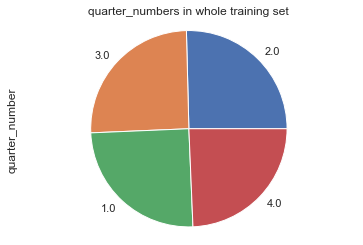

In [117]:
#displaying pie-chart

X_train['quarter_number'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('quarter_numbers in whole training set')
plt.show()

* Looks pretty symmtetric

#### White vs Ransomware

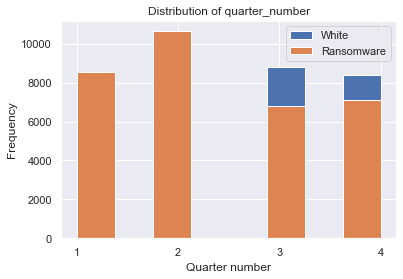

In [118]:
#Displaying histogram of quarter_number feature

undersampled_df['quarter_number'].plot(kind = 'hist', bins=8, label='White')
positive_df['quarter_number'].plot(kind = 'hist', bins=8, label='Ransomware')
plt.xlabel('quarter_number')
plt.title('Distribution of quarter_number')
plt.xlabel('Quarter number')
plt.xticks([1, 2, 3, 4])
plt.legend()
plt.show()

* Transactions made in the third and fourth quarter are more likely to be white rather than ransomware

### 3.15 Gaussian Income
* Feature corrects for the skewness in Income feature. Let us see how it changes with the target variable.

#### Looking at its distribution

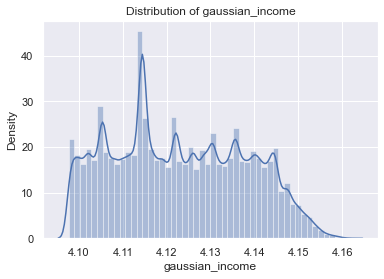

In [119]:
#plotting pdf

sns.distplot(X_train['gaussian_income'])
plt.title('Distribution of gaussian_income')
plt.show()

#### White vs Ransomware

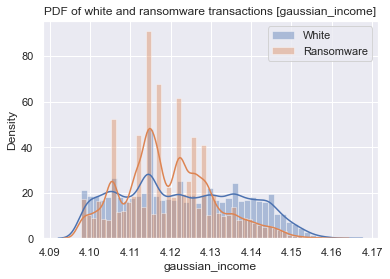

In [120]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['gaussian_income'], label = 'White')
sns.distplot(positive_df['gaussian_income'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [gaussian_income]')
plt.show()

* There is a considerable amount of difference in both the distributions

### 3.16 Gaussian neighbors
* Feaute corrects for skewness in neighhbors feature. Let us see how it affects the target variable.

####  Looking at its distribution

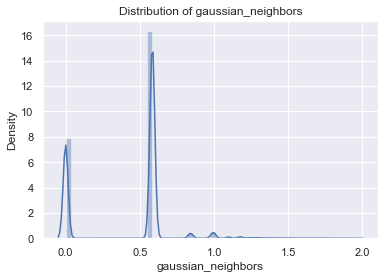

In [121]:
#plotting pdf

sns.distplot(X_train['gaussian_neighbors'])
plt.title('Distribution of gaussian_neighbors')
plt.show()

#### White vs Ransomware

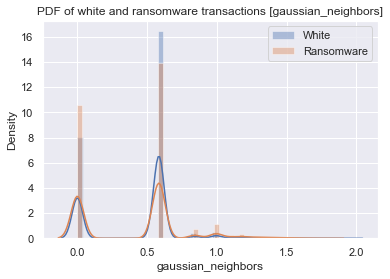

In [122]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['gaussian_neighbors'], label = 'White')
sns.distplot(positive_df['gaussian_neighbors'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [gaussian_neighbors]')
plt.show()

* The PDF's have a little difference around the 0.5-0.7 mark

### 3.17 Gaussian weight
* Feature corrects for skewness in weight feature. Let us see how it affects the target variable.

#### Looking at its distribution

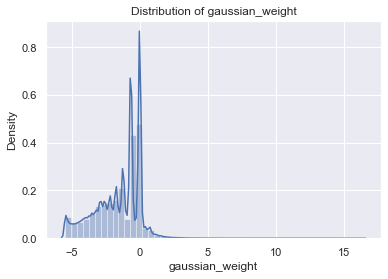

In [123]:
#plotting pdf

sns.distplot(X_train['gaussian_weight'])
plt.title('Distribution of gaussian_weight')
plt.show()

#### White vs Ransomware

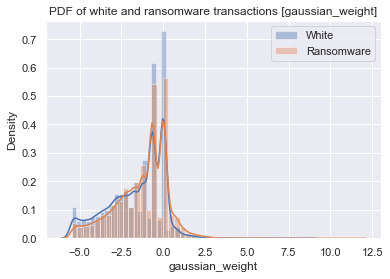

In [124]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['gaussian_weight'], label = 'White')
sns.distplot(positive_df['gaussian_weight'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [gaussian_weight]')
plt.show()

* We notice a slight amount of separability between the two classes

### 3.18 Gaussian length
* Feature corrects for skewness in length feature. Let us see how it affects the target variable.

#### Looking at its distribution

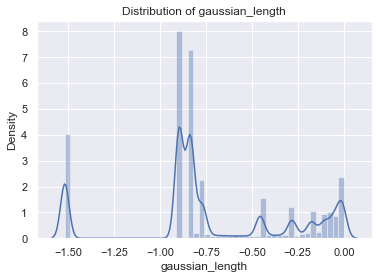

In [125]:
#plotting pdf

sns.distplot(X_train['gaussian_length'])
plt.title('Distribution of gaussian_length')
plt.show()

#### White vs Ransomware

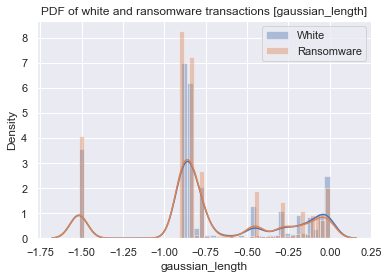

In [126]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['gaussian_length'], label = 'White')
sns.distplot(positive_df['gaussian_length'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [gaussian_length]')
plt.show()

* The PDFs look almost identical, thereby indicating no amount of separability.

### 3.19 Log count
* Feature corrects for skewness in count feature. Let us see how it affects the target variable.

#### Looking at its distribution

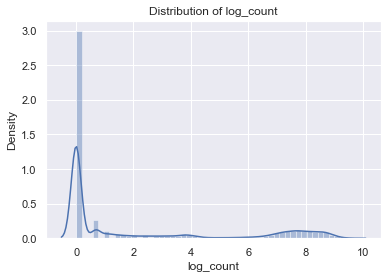

In [127]:
#plotting pdf

sns.distplot(X_train['log_count'])
plt.title('Distribution of log_count')
plt.show()

#### White vs Ransomware

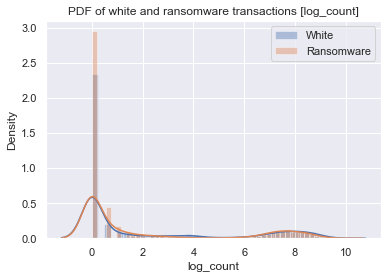

In [128]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['log_count'], label = 'White')
sns.distplot(positive_df['log_count'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [log_count]')
plt.show()

### 3.20 Sigmoid looped
* Feature corrects for skewness in looped feature. Let us see how it affects the target variable.

#### Looking at its distribution

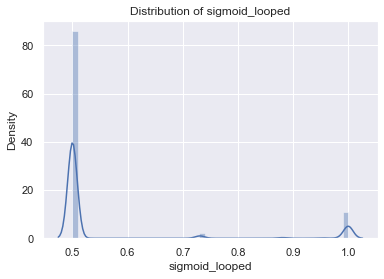

In [129]:
#plotting pdf

sns.distplot(X_train['sigmoid_looped'])
plt.title('Distribution of sigmoid_looped')
plt.show()

#### White vs ransomware

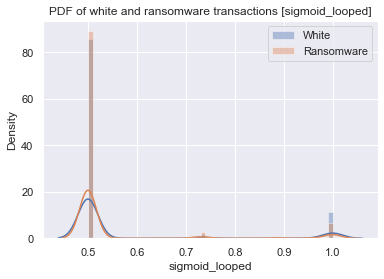

In [130]:
#plotting pdfs of white and ransomware

sns.distplot(undersampled_df['sigmoid_looped'], label = 'White')
sns.distplot(positive_df['sigmoid_looped'], label = 'Ransomware')
plt.legend()
plt.title('PDF of white and ransomware transactions [sigmoid_looped]')
plt.show()

* We see that this engineered feature gives us some amount of separability when the value is between 0.4 and 0.6

### 3.21 Interaction: count and income
* Feature has been engineered by applying transformation functions on count and income and combining them. Let us see how it affects our target variable.

#### Looking at its distribution

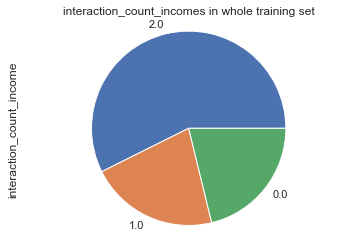

In [131]:
#displaying pie-chart

X_train['interaction_count_income'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('interaction_count_incomes in whole training set')
plt.show()

#### White vs Ransomware

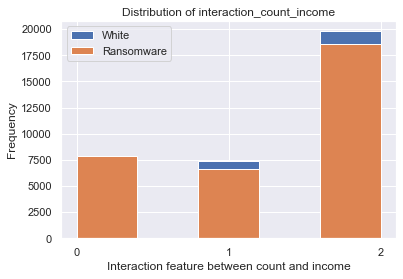

In [132]:
#Displaying histogram of interaction_count_income feature

undersampled_df['interaction_count_income'].plot(kind = 'hist', bins=5, label='White')
positive_df['interaction_count_income'].plot(kind = 'hist', bins=5, label='Ransomware')
plt.xlabel('interaction_count_income')
plt.title('Distribution of interaction_count_income')
plt.xlabel('Interaction feature between count and income')
plt.xticks([0, 1, 2])
plt.legend()
plt.show()

* Transactions with this feature being equal to 1 and 2 are slightly more likely to be white

### 3.22 Interaction: weight and length
* Feature has been engineered by applying transformation functions on weight and length and combining them. Let us see how it affects our target variable.

#### Looking at its distribution

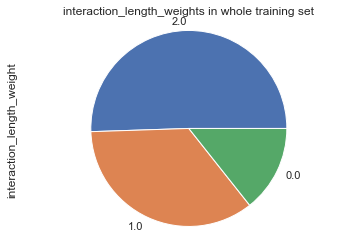

In [133]:
#displaying pie-chart

X_train['interaction_length_weight'].value_counts().plot(kind='pie')
plt.axis('equal')
plt.title('interaction_length_weights in whole training set')
plt.show()

#### White vs Ransomware

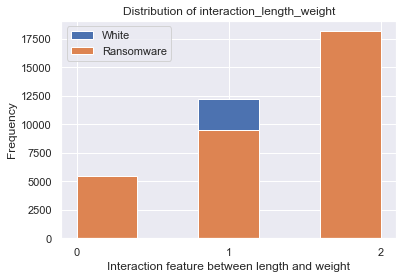

In [134]:
#Displaying histogram of interaction_length_weight feature

undersampled_df['interaction_length_weight'].plot(kind = 'hist', bins=5, label='White')
positive_df['interaction_length_weight'].plot(kind = 'hist', bins=5, label='Ransomware')
plt.xlabel('interaction_length_weight')
plt.title('Distribution of interaction_length_weight')
plt.xlabel('Interaction feature between length and weight')
plt.xticks([0, 1, 2])
plt.legend()
plt.show()

* Transactions with this feature being equal to 1 is significanly more probable to be white than ransomware

### 3.23 Target variable
* This is the variable we wish to predict. Let us see how it is distributed

#### Looking at its distribution

	 Distribution of target variable


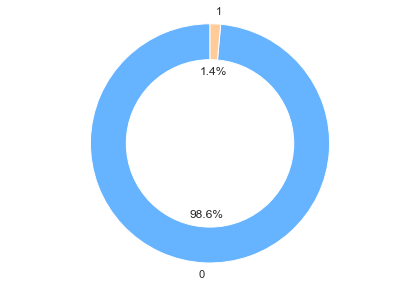

In [135]:
#code to print pie chart

print('\t Distribution of target variable')
labels = [0, 1]
sizes = [pd.Series(y_train).value_counts()[0], pd.Series(y_train).value_counts()[1]]
explode = (0, 0.1)
colors = ['#66b3ff','#ffcc99']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()

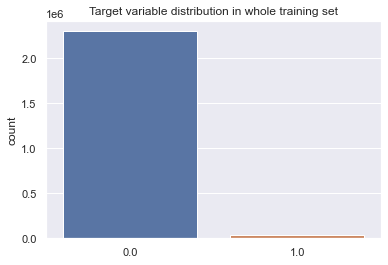

In [136]:
#count plot

sns.set_theme(style='darkgrid')
sns.countplot(y_train)
plt.title('Target variable distribution in whole training set')
plt.show()

* Like we expected, it an extremely imbalanced data-set

# 4.0 Multi-variate analysis
* Multivariate analysis (MVA) is based on the principles of multivariate statistics, which involves observation and analysis of more than one statistical outcome variable at a time. Typically, MVA is used to address the situations where multiple measurements are made on each experimental unit and the relations among these measurements and their structures are important.

In [137]:
#Creating a new dataframe with same number of positive and negative class datapoints

balanced_df = undersampled_df.sample(500)
balanced_df = balanced_df.append(positive_df.sample(500))
balanced_df['labels'] = np.append([0] * 500, [1] * 500)

In [138]:
balanced_df

,address,year,day,length,weight,count,looped,neighbors,income,n_address,...,quarter_number,gaussian_income,gaussian_neighbors,gaussian_weight,gaussian_length,log_count,sigmoid_looped,interaction_count_income,interaction_length_weight,labels
27196,16mpDrnPZAnzqJL1YmBw8rmHU64Wcq6cvc,2011,111,2,0.250000,1,0,1,3.000000e+09,0.000000,...,2.0,4.142323,9.999992e-07,-1.224973,-1.517133,9.999995e-07,0.5,2.0,2.0,0
7181,3KGbJy8ZN4dHXkCaWUdzhd23Nkxoot9xJk,2018,146,8,0.010989,1,0,1,3.458733e+07,0.000000,...,2.0,4.099943,9.999992e-07,-3.074981,-0.281585,9.999995e-07,0.5,2.0,2.0,0
5670,1HQKK478FLBguzFNoLcKhBNfUdQ4rs9gzG,2017,356,140,0.463698,788,0,2,3.582246e+08,0.000000,...,4.0,4.127628,5.841690e-01,-0.717108,-0.809330,6.669498e+00,0.5,0.0,0.0,0
25854,12YSrSSoE4xT2CMBAT6p6Nr6GFmFkMy5fd,2015,187,0,1.000000,1,0,1,9.277377e+07,0.038124,...,3.0,4.113539,9.999992e-07,0.000000,-0.895193,9.999995e-07,0.5,2.0,2.0,0
2968,1HGqmCkRc2BNtcQmTsVEjLYAyJoJxhHng2,2016,17,144,0.271038,1058,0,2,4.027000e+07,0.000000,...,1.0,4.102254,5.841690e-01,-1.161754,-0.835022,6.964136e+00,0.5,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10940,1DF6i4UfBdCjmunsJHMJTva8D3RYdvSMsr,2016,119,144,0.055788,1720,985,4,5.100000e+08,0.000000,...,2.0,4.130618,9.948198e-01,-2.244186,-0.835022,7.450080e+00,1.0,0.0,1.0,1
16236,17AGazRCLStNguMDCxDoj7ZQHvaZBWTJZj,2014,156,40,7.265636,28,0,11,1.345300e+09,0.038124,...,2.0,4.137636,1.385626e+00,2.389102,-0.074840,3.332205e+00,0.5,0.0,0.0,1
26092,126sk8mK4pKPGStciNssscEoEU8eeiqoUV,2013,261,0,3.000000,3,0,5,1.040000e+09,0.038124,...,3.0,4.135930,1.099063e+00,1.216368,-0.895193,1.098613e+00,0.5,0.0,2.0,1
13848,18FLw2Sqqr84TvMpxU3uBvJf4PwJZjDh6j,2017,95,2,0.500000,1,0,2,8.000000e+07,0.000000,...,2.0,4.111697,5.841690e-01,-0.651137,-1.517133,9.999995e-07,0.5,2.0,2.0,1


### Pair plots 
* Pairs plots let us see how points in a feature are distributed with respect to other features. 

[]

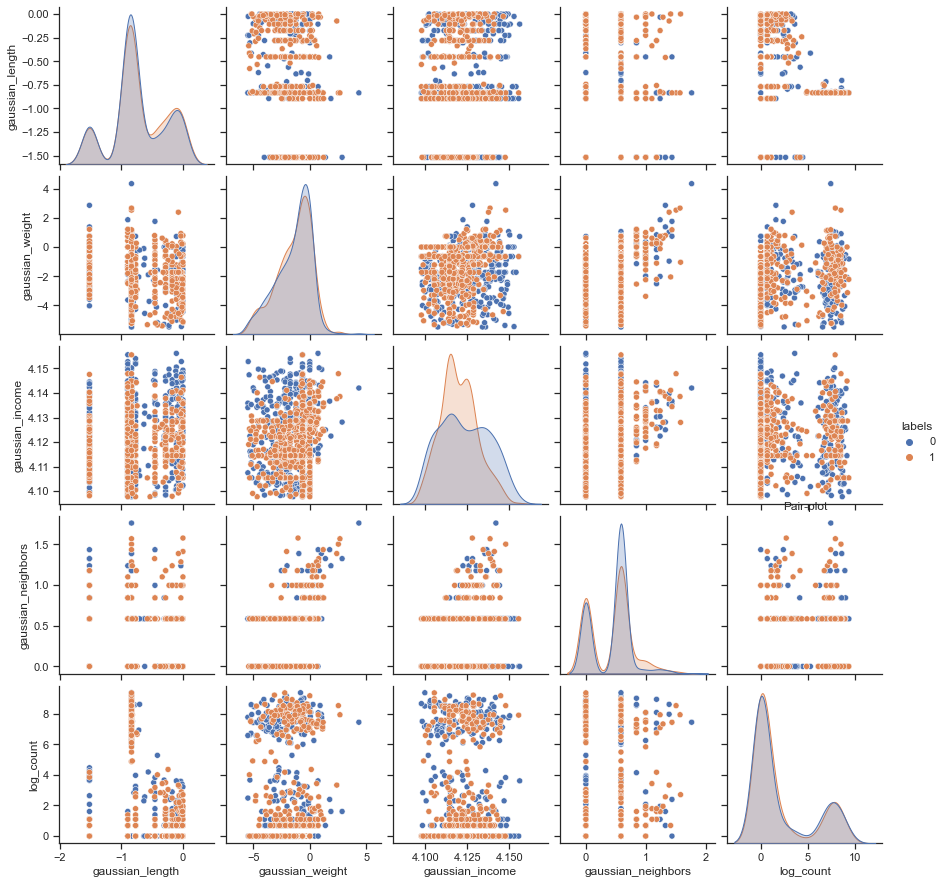

In [139]:
#plotting pair plots

sns.set_theme(style='ticks')
sns.pairplot(balanced_df[['gaussian_length',
                      'gaussian_weight',
                      'gaussian_income',
                      'gaussian_neighbors',
                      'log_count',
                      'labels'
                     ]], hue='labels')


plt.title('Pair-plot')
plt.plot()

### Correlations
* Correlation is a term that is a measure of the strength of a linear relationship between two quantitative variables (e.g., height, weight).

In [140]:
X_train.corr()

,year,day,length,weight,count,looped,neighbors,income,n_address,day_of_week,is_close_to_holiday,quarter_number,gaussian_income,gaussian_neighbors,gaussian_weight,gaussian_length,log_count,sigmoid_looped,interaction_count_income,interaction_length_weight
year,1.000000,-4.031641e-02,0.163223,0.011742,0.285714,0.113152,-0.001148,-0.021044,-0.210614,-0.002276,-0.004031,-0.034758,-0.282398,7.791433e-02,0.115092,-0.067485,0.148971,0.025569,0.027188,-0.085703
day,-0.040316,1.000000e+00,0.011836,0.000928,-0.002269,0.002954,0.000185,0.002973,-0.010892,0.001221,0.047284,0.967575,-0.022637,-4.668905e-08,-0.008053,-0.004481,0.009084,-0.003534,-0.005771,-0.000413
length,0.163223,1.183619e-02,1.000000,0.000665,0.703332,0.411354,0.031472,0.000539,-0.094337,-0.027603,-0.004637,0.007624,-0.016200,2.325419e-01,-0.355183,0.020971,0.902035,0.471085,-0.582046,-0.657991
weight,0.011742,9.282071e-04,0.000665,1.000000,0.023062,0.062714,0.680173,0.072098,0.047539,0.003279,0.000928,0.001282,0.054831,1.040039e-01,0.224289,-0.030779,0.015996,0.055089,-0.039914,-0.035224
count,0.285714,-2.268535e-03,0.703332,0.023062,1.000000,0.559790,0.025378,-0.003888,-0.056523,-0.049389,0.016517,-0.005753,-0.052038,1.227266e-01,-0.119160,-0.105780,0.797897,0.376559,-0.430322,-0.404339
looped,0.113152,2.954478e-03,0.411354,0.062714,0.559790,1.000000,0.052801,0.002275,-0.010365,-0.031976,0.006390,-0.000701,0.020773,1.764372e-01,-0.074745,-0.064379,0.459501,0.664493,-0.277148,-0.235004
neighbors,-0.001148,1.854476e-04,0.031472,0.680173,0.025378,0.052801,1.000000,0.139024,0.046871,0.000838,-0.000219,0.000122,0.050426,1.344037e-01,0.089653,-0.004957,0.035469,0.070104,-0.047007,-0.038408
income,-0.021044,2.973484e-03,0.000539,0.072098,-0.003888,0.002275,0.139024,1.000000,0.000658,-0.001647,-0.000496,0.002461,0.058291,1.749479e-02,0.001099,0.006540,-0.004129,0.003340,-0.004996,-0.005089
n_address,-0.210614,-1.089163e-02,-0.094337,0.047539,-0.056523,-0.010365,0.046871,0.000658,1.000000,0.004120,-0.002648,-0.011096,-0.019095,-7.014451e-02,-0.002000,-0.068349,-0.017225,0.028223,-0.091314,0.058706
day_of_week,-0.002276,1.221304e-03,-0.027603,0.003279,-0.049389,-0.031976,0.000838,-0.001647,0.004120,1.000000,0.001032,0.000616,-0.005415,-6.838685e-03,0.016422,0.006652,-0.032149,-0.006812,0.017723,0.006502


### Correlation map
* Correlation map shows how correlated sets of features are. Darker the color in the box, higher is the correlation between the corresponding features

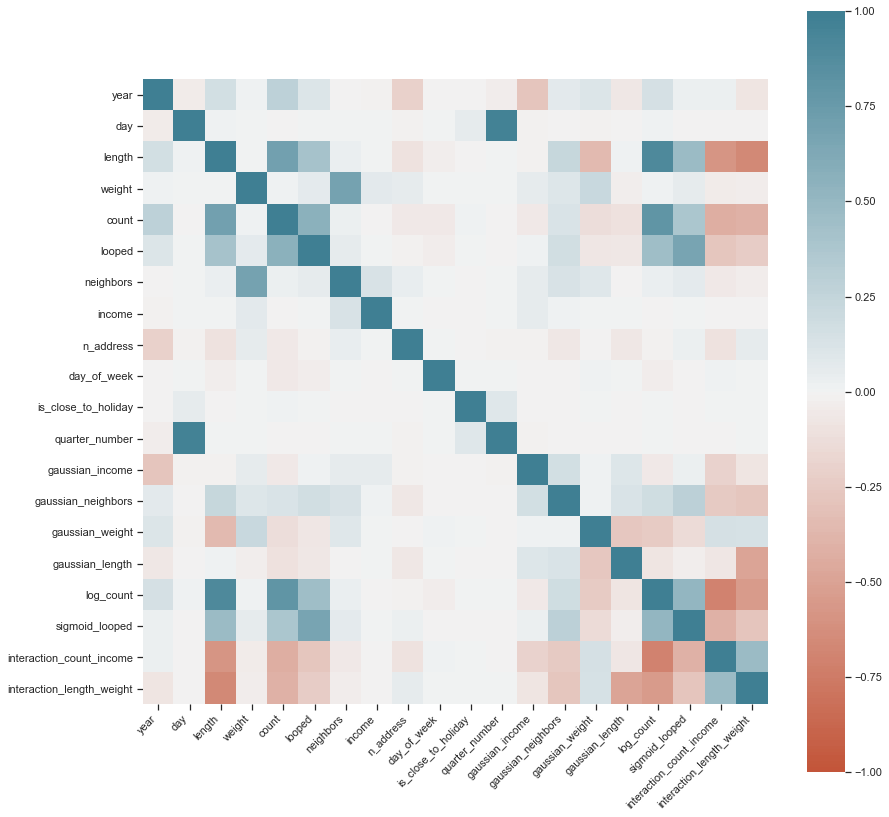

In [141]:
#plotting correlation map
# +1 and -1 mean fully-correlated features

corr = X_train.corr()
plt.figure(figsize=(14, 14))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### 4.1 gaussian income and log count

* Gaussian-income and log-count fix the skewnesss of the respective features by applying transformations. Generally speaking, for models like Logistic Regression, maximum predictive power can be achieved if the features are distributed normally or if their PDF looks like a 'bell curve'.

* We now visualize how both of these features when combined, affect our target variable

[]

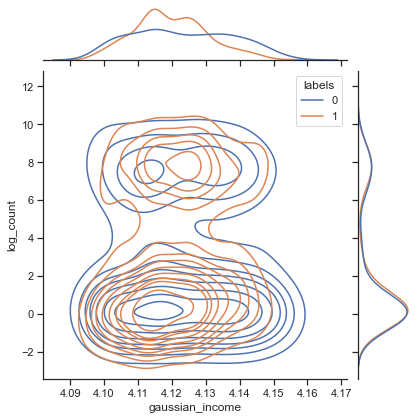

In [142]:
#plotting kde maps
#KDE or Kernel Density Maps plot the probability density of a continous variable
#probability density of a continous variable gives us the probability of find a continous variable at a particular interval
#of points.

#In the below plot, smaller the 'circle', higher is the probability density function of the combined variables (since we're
#using 2D KDE plot to measure affect of two variables at the same time)

sns.jointplot(data=balanced_df, x='gaussian_income', y='log_count', hue='labels', kind = 'kde')
plt.plot()

* In the above plot, we want the blue lines and orange lines two be as separable as possible. If they are completely overlapping, that means the feature does not change whether the target variable is 1 or 0. However, in our case, there is a considerable amount of separability so these features will definetely contribute to predicting the target variable.

* The combined distributions look similar but when income is high, for positive class, log_count is more widely spread than negative class

[]

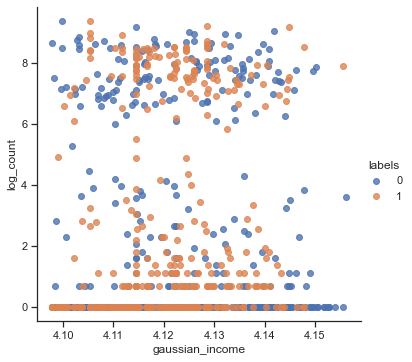

In [143]:
#plotting lm plots

#lm plots are just scatter plots. they let us see how features change with respect to other features

sns.lmplot(x='gaussian_income', y='log_count', hue='labels', data=balanced_df, fit_reg = False)
plt.plot()

### 4.2 Gaussian length and gaussian weight
* Gaussian length and gaussian weight also correct the skewness of their original feature values. We now visualize how when both of these features are combined, affect our target variable.

[]

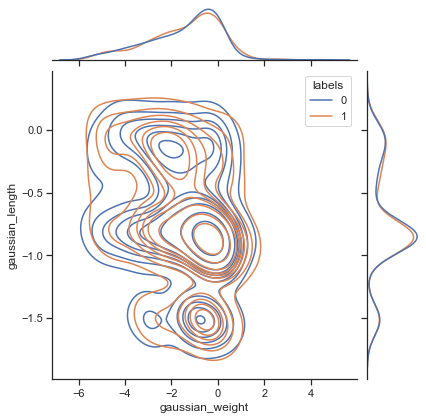

In [144]:
#plotting kde maps

#In the below plot, smaller the 'circle', higher is the probability density function of the combined variables (since we're
#using 2D KDE plot to measure affect of two variables at the same time)

sns.jointplot(data=balanced_df, x='gaussian_weight', y='gaussian_length', hue='labels', kind = 'kde')
plt.plot()

* In the above plot, we want the blue lines and orange lines two be as separable as possible. If they are completely overlapping, that means the feature does not change whether the target variable is 1 or 0. In our case, there is very little separability, indicating that these features might not add much importance to our dataset.

* The combined distributions look to be marginally separable if any.

[]

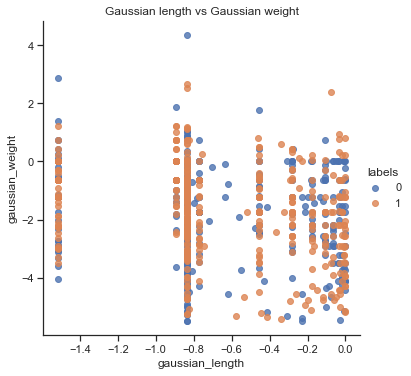

In [145]:
#plotting lm plots

sns.lmplot(x='gaussian_length', y='gaussian_weight', hue='labels', data=balanced_df, fit_reg = False)
plt.title('Gaussian length vs Gaussian weight')
plt.plot()

### 4.3 gaussian_income and day of week
* Gaussian income corrects for its original feature's skewness and day of week is 0 for Mondays and 6 for Sundays and so on.
* We want to see if there is an increase (or decrease) in income depending on the day of the week

[]

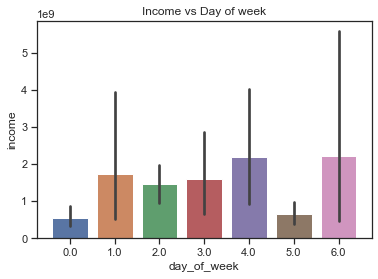

In [146]:
#plotting bar plot

sns.barplot(x='day_of_week', y='income', data=balanced_df)
plt.title('Income vs Day of week')
plt.plot()

* It is evident that income is highest on Fridays

### 4.4 gaussian_income vs quarter number
* Gaussian income corrects for its original feature's skewness and quarter number is 1 for January-April, 4 for Sept-Dec and so on.
* We want to see if there is an increase (or decrease) in income depending on what quarter of the year it is.

[]

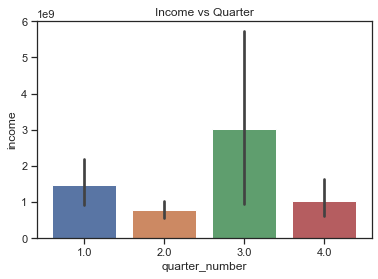

In [147]:
#plotting bar plot

sns.barplot(x='quarter_number', y='income', data=balanced_df)
plt.title('Income vs Quarter')
plt.plot()

* It is evident that most of the income is in Q4

### 4.5 Sigmoid looped and gaussian weight
* Sigmoid looped corrects the skewness of its original feature looped, which indicated the count of transactions (over a given set of criteria) and gaussian weight corrects the skewness of its original feature, weight.
* We want to see how both of these features, when combined, affect our target variable

[]

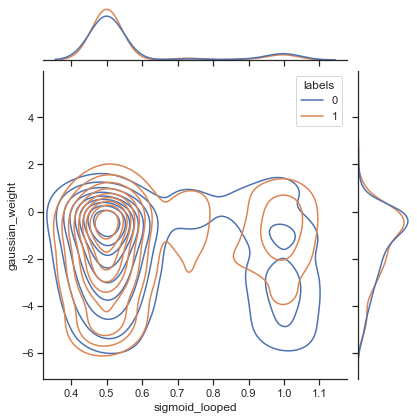

In [148]:
#plotting kde maps

#In the below plot, smaller the 'circle', higher is the probability density function of the combined variables (since we're
#using 2D KDE plot to measure affect of two variables at the same time)

sns.jointplot(data=balanced_df, x='sigmoid_looped', y='gaussian_weight', hue='labels', kind = 'kde')
plt.plot()

* There appears to be a good separability between the combined distributions

### 4.6 Income and holidays
* We want to see if there is a higher (or lower) income during holidays

[]

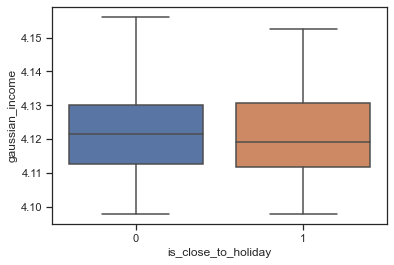

In [149]:
#plotting box plots

#The line in the middle of the 'box' indicates the median value. The upper bound of the box indicates the 75th percentile
#and lower bound 25th percentile. 

#The more different the lines and boxes appear, the higher value they add to our data.

sns.boxplot(data=balanced_df, y = 'gaussian_income', x='is_close_to_holiday')
plt.plot()

* Income generated does not seem to be very correlated with is_close_holiday

### 4.7 Income and years
* We want to see how income has changed over the years

C:\Users\yogid\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 10.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\yogid\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 14.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\yogid\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 18.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\yogid\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 18.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\yogid\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 55.2% of the points

[]

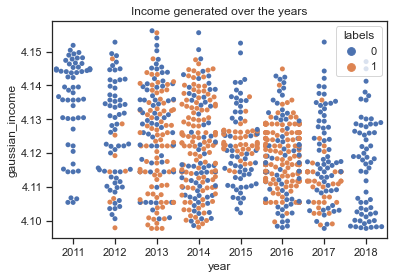

In [150]:
#plotting swarm plots

#Swarm plots show us how the scatter plot changed over time

#We can see that in the year 2014 although income reduced a little, a large number of transactions were infact for ransomware.

sns.swarmplot(data = balanced_df, x='year', y='gaussian_income', hue='labels')
plt.title('Income generated over the years')
plt.plot()

### 4.8 Income, years and interaction_count_income
* We want to see how income changed over the year and how these features affect another feature which is an interaction feature between count and income

C:\Users\yogid\anaconda3\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 22.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


[]

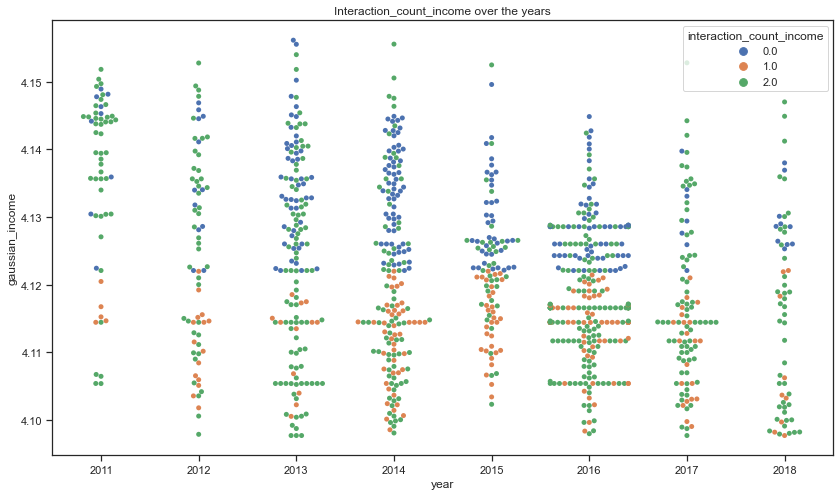

In [151]:
#plotting swarm plots

plt.figure(figsize=(14, 8))
sns.swarmplot(data = balanced_df, x='year', y='gaussian_income', hue='interaction_count_income')
plt.title('Interaction_count_income over the years')
plt.plot()

* We can see that our interaction feature has changed over the years. Around the year 2014 most of higher income data-points are all belonging to type 0 but later in year 2018, most of them belong to type 2.

# 5.0 Modelling

## Metrics

*Key Performance Indicator* : <b>Recall</b>

- Recall tells us of all the data-points in the data-set that are actually positive, what percentage of them have we predicted to be positive.

#### Why?
- We want to correctly classify as many positive data-points (ransomware transactions) as possible even if it means we incorreclty classify a few white transactions to be of type ransomware also. A domain expert can validate our results and filter out the false positives. We want maximum recall.

#### Other metrics:
- *Log-loss*: A loss function that has no specific range. Lower is better.
- *Precision*: Tells us what percentage of data-points that we classified as positive, are infact positive. Higher is better.
- *ROCAUC*: Uses True Positive Rate and False Positive Rate to get area under the curve. Higher is better.
- *F1-Score*: Harmonic mean of precision and recall. Higher is better.
- *Accuracy*: Tells us how accurate our predictions are. Higher is better

In [152]:
#taking a sub-df of all the positive class datapoints for comparison

temp_df = pd.DataFrame(X_train_distance)

positive_df = pd.DataFrame([], columns = temp_df.columns)
negative_df = pd.DataFrame([], columns = temp_df.columns)
index = 0

for index_df, row in tqdm(temp_df.iterrows(), total=temp_df.shape[0]):
    if y_train[index] == 0:
        if np.random.uniform(0, 1) < 0.015:
            #picking negative class with a probability of 1.5%
            
            #Why 1.5%?
            #Because only 1.5% of our data-points in the original data
            #belong to positive class and hence we want to get same 
            #number of negative data points
            
            negative_df = negative_df.append(row, ignore_index=True)
            index += 1
        else:
            index += 1

    elif y_train[index] == 1:
        #picking all positive data-points
        positive_df = positive_df.append(row, ignore_index=True)
        index += 1

In [153]:
combined_df = positive_df.append(negative_df, ignore_index = True)
combined_labels = np.append([1] * positive_df.shape[0], [0] * negative_df.shape[0])

In [154]:
combined_df

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-1.096544,-1.225571,-0.763299,0.120584,-0.426614,-0.246761,-0.011472,-0.027096,2.671250,-0.232848,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.675443,0.360724,1.677657,-0.078485,0.610045,-0.246761,-0.011472,-0.027541,-0.374357,-0.702006,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,-0.653547,1.004857,1.101320,0.079377,-0.410648,-0.246761,-0.011472,-0.027837,2.671250,-1.439692,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
3,0.675443,0.927945,1.677657,-0.132340,0.592304,-0.246761,-0.011472,-0.027318,-0.374357,-0.423330,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,0.675443,-0.687192,-0.763299,-0.012475,-0.426614,-0.246761,-0.011472,-0.027286,-0.374357,-0.391837,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67801,0.675443,-0.696806,1.677657,-0.023063,2.565683,2.635526,-0.011472,-0.025546,-0.374357,0.377769,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
67802,-0.653547,1.341344,-0.695495,0.652819,-0.426023,-0.244692,0.044524,-0.024693,-0.374357,0.538711,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
67803,1.118440,1.706672,1.609853,-0.145532,2.775025,-0.246761,-0.067468,-0.027856,-0.374357,-1.523945,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
67804,0.232446,-0.225724,1.677657,-0.143666,0.643161,1.524408,-0.011472,-0.027158,-0.374357,-0.280356,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


## 5.1 Modelling - Random model

#### Why?
- To have a baseline. Some of the metrics we use (such as log-loss) do not have a specific range. We can use the output of a random model as the worst case

### Random model

In [155]:
class RandomModel():
    '''
    This class predicts class labels randomly and is meant
    to be used as a baseline for metrics that don't have a specific range
    like log-loss.
    '''
    
    def predict(self, X):
        #predict class labels randomly
        
        y_pred = np.array([])
        for data_point in tqdm(range(X.shape[0])):
            if np.random.uniform(0, 1) >= 0.5:
                y_pred = np.append(y_pred, 1)
            else:
                y_pred = np.append(y_pred, 0)
        return y_pred

In [156]:
random_model = RandomModel()
random_pred = random_model.predict(X_test_distance)

In [157]:
#displaying the table

random_table = PrettyTable()
random_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  'Log-loss'
                 ]

#random_pred = random_model.predict(X_test_distance)

random_table.add_row([
    'Random Model',
    accuracy_score(y_true = y_test, y_pred = random_pred),
    f1_score(y_true = y_test, y_pred = random_pred),
    precision_score(y_true = y_test, y_pred = random_pred),
    recall_score(y_true = y_test, y_pred = random_pred),
    log_loss(y_true = y_test, y_pred = random_pred)
])

print(random_table)

+--------------+--------------------+---------------------+----------------------+--------------------+-------------------+
|  Model Name  |      Accuracy      |       F1-Score      |      Precision       |       Recall       |      Log-loss     |
+--------------+--------------------+---------------------+----------------------+--------------------+-------------------+
| Random Model | 0.5004388521274042 | 0.02782281470806061 | 0.014306740636289717 | 0.5034407823252445 | 17.25462459198374 |
+--------------+--------------------+---------------------+----------------------+--------------------+-------------------+


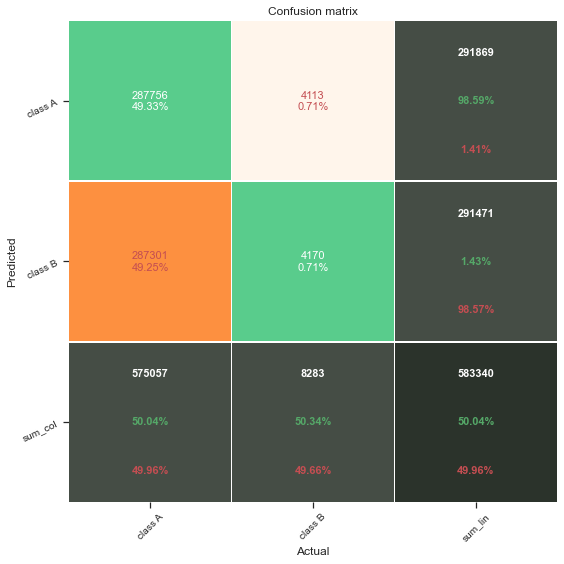

In [169]:
#plotting confusion matrix

conf_matrix(
    y_test = y_test,
    predictions = random_pred,
    #figsize = [1, 2]
)

In [159]:
#Building a smaller balanced data-set for hyper-paramter tuning

combined_X_train, combined_X_test, combined_y_train, combined_y_test = train_test_split(
    combined_df,
    combined_labels,
    test_size = 0.2,
    shuffle = True,
    random_state = 42
)

#### Helper method

In [160]:
#method to print better looking plots

def pretty_importances_plot(importances, feature_name, fig_size = (10, 7), xlabel = '', ylabel = '', horizontal_label = None, n_elements=None):
    '''
    This function plots a better looking importances-plot
    
    importances: Occurences of feature_name
    feature_name: unique feature_name
    fig_size: size of plot
    xlabel: xlabel
    ylabel: ylabel
    horizontal_label: Bigger label at the top-left
    n_elements: number of elements to display
    '''
    
    # This code has been borrowed from:
    # https://scentellegher.github.io/visualization/2018/10/10/beautiful-bar-plots-matplotlib.html
    # Credits to SIMONE CENTELLEGHER

    # set the style of the axes and the text color
    plt.rcParams['axes.edgecolor']='#333F4B'
    plt.rcParams['axes.linewidth']=0.8
    plt.rcParams['xtick.color']='#333F4B'
    plt.rcParams['ytick.color']='#333F4B'
    plt.rcParams['text.color']='#333F4B'

    # percentages = pd.Series(data= list(map(operator.itemgetter(1), word_importances_title_entity)),
    #                       index = list(map(operator.itemgetter(0), word_importances_title_entity)))
    
    
    if not n_elements:
        n_elements = len(importances)
    
    percentages = pd.Series(
        data = importances[:n_elements],
        index = feature_name[:n_elements]
    )

    df = pd.DataFrame({'percentage' : percentages})
    df = df.sort_values(by='percentage')

    # we first need a numeric placeholder for the y axis
    my_range=list(range(1,len(df.index)+1))

    #fig, ax = plt.subplots(figsize=(5,3.5)) ######################
    fig, ax = plt.subplots(figsize=fig_size)


    # create for each expense type an horizontal line that starts at x = 0 with the length 
    # represented by the specific expense percentage value.
    plt.hlines(y=my_range, xmin=0, xmax=df['percentage'], color='#007ACC', alpha=0.2, linewidth=5)

    # create for each expense type a dot at the level of the expense percentage value
    plt.plot(df['percentage'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

    # set labels
    ax.set_xlabel(xlabel, fontsize=15, fontweight='black', color = '#333F4B')
    ax.set_ylabel(ylabel)

    # set axis
    ax.tick_params(axis='both', which='major', labelsize=12)
    plt.yticks(my_range, df.index)

    # add an horizonal label for the y axis
    if horizontal_label:
        fig.text(-0.23, 0.96, horizontal_label, fontsize=15, fontweight='black', color = '#333F4B')

    # change the style of the axis spines
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_smart_bounds(True)
    ax.spines['bottom'].set_smart_bounds(True)

    # set the spines position
    ax.spines['bottom'].set_position(('axes', -0.04))
    ax.spines['left'].set_position(('axes', 0.015))

## 5.2 Modelling - Distance based models
* Distance-based models are based on the geometry of data. As the name implies, distance-based models work on the concept of distance.

### 5.2.1 Logistic Regression
* Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable.

In [162]:
#getting sgd classifier to perfrom hyper-paramter tuning
from sklearn.linear_model import SGDClassifier

lr_sgd = SGDClassifier(
    loss = 'log',
    penalty = 'elasticnet',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

lr_sgd.fit(combined_X_train, combined_y_train)

SGDClassifier(class_weight='balanced', loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

In [163]:
#hyper-paramter tuning

lr_hyperparam = RandomizedSearchCV(
    estimator = lr_sgd,
    param_distributions = {
        'alpha' : [0.001, 0.01, 0.1, 1.0, 10]
    },
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1,
    random_state = 42,
    return_train_score = True,
    n_iter = 25
)

lr_hyperparam.fit(combined_X_train, combined_y_train)

C:\Users\yogid\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:278: UserWarning: The total space of parameters 5 is smaller than n_iter=25. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.1s finished


RandomizedSearchCV(estimator=SGDClassifier(class_weight='balanced', loss='log',
                                           n_jobs=-1, penalty='elasticnet',
                                           random_state=42),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'alpha': [0.001, 0.01, 0.1, 1.0, 10]},
                   random_state=42, return_train_score=True, scoring='f1',
                   verbose=1)

In [164]:
#our best alpha is 0.001

lr_hyperparam.best_params_

{'alpha': 0.001}

In [165]:
lr_full = SGDClassifier(
    alpha = 0.001,
    loss = 'log',
    penalty = 'elasticnet',
    n_jobs = -1,
    random_state = 42,
    class_weight = 'balanced'
)

lr_full.fit(X_train_distance, y_train)

SGDClassifier(alpha=0.001, class_weight='balanced', loss='log', n_jobs=-1,
              penalty='elasticnet', random_state=42)

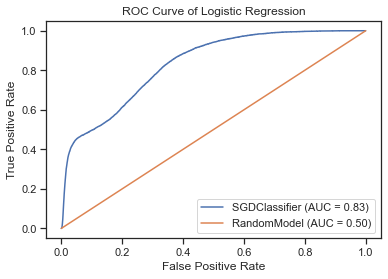

In [166]:
plot_roc_curve(
    lr_full,
    X_test_distance,
    y_test
)
plt.title('ROC Curve of Logistic Regression')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
plt.legend()
plt.show()

In [167]:
lr_table = PrettyTable()
lr_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  'Log-loss'
                 ]

lr_preds = lr_full.predict(X_test_distance)

lr_table.add_row([
    'Logistic Regression',
    accuracy_score(y_true = y_test, y_pred = lr_preds),
    f1_score(y_true = y_test, y_pred = lr_preds),
    precision_score(y_true = y_test, y_pred = lr_preds),
    recall_score(y_true = y_test, y_pred = lr_preds),
    log_loss(y_true = y_test, y_pred = lr_preds)
])

print(lr_table)

+---------------------+--------------------+--------------------+----------------------+--------------------+-------------------+
|      Model Name     |      Accuracy      |      F1-Score      |      Precision       |       Recall       |      Log-loss     |
+---------------------+--------------------+--------------------+----------------------+--------------------+-------------------+
| Logistic Regression | 0.8633781328213392 | 0.0981951909476662 | 0.054175198521700045 | 0.5238440178679222 | 4.718855957502188 |
+---------------------+--------------------+--------------------+----------------------+--------------------+-------------------+


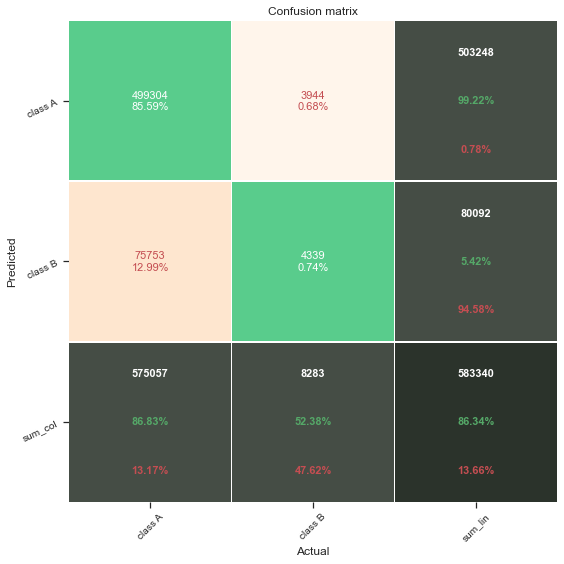

In [170]:
conf_matrix(
    #estimator = lr_full,
    #X = X_test_distance,
    y_test = y_test,
    predictions = lr_full.predict(X_test_distance)
)

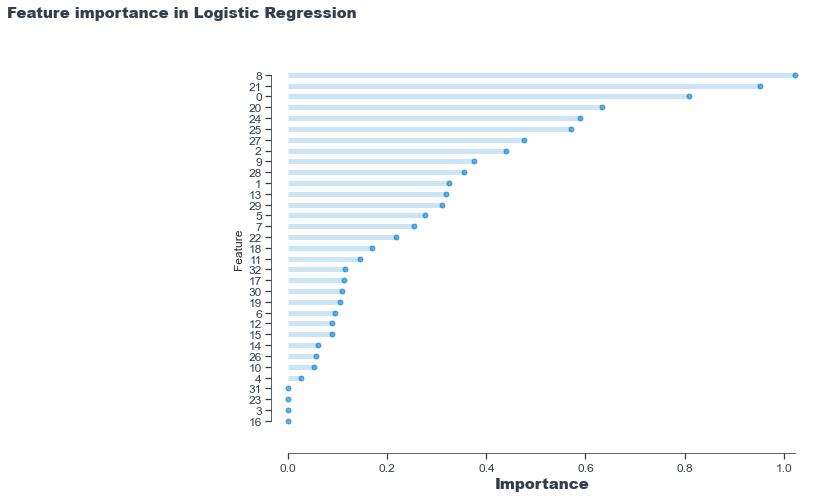

In [171]:
#Feauture importance tells us what the role each feature plays in predicting the target variable

pretty_importances_plot(
    np.abs(lr_full.coef_[0]), 
    [i for i in range(X_train_distance.shape[1])],
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in Logistic Regression'
)

### 5.2.2 Support vector machines
* The support-vector clustering algorithm, created by Hava Siegelmann and Vladimir Vapnik, applies the statistics of support vectors, developed in the support vector machines algorithm, to categorize unlabeled data, and is one of the most widely used clustering algorithms in industrial applications.

In [ ]:
from sklearn.svm import SVC

#Hyper-paramter tuning
svc_hyperparams = RandomizedSearchCV(
    estimator = SVC(),
    param_distributions = {
        'C' : [0.001, 0.01, 0.1, 1.0, 10]
    },
    scoring = 'f1',
    n_jobs = -1,
    verbose = 5,
    random_state = 42,
    return_train_score = True,
    n_iter = 10
)

svc_hyperparams.fit(combined_X_train, combined_y_train)

In [ ]:
#best hyper-parameter
svc_hyperparams.best_params_

In [ ]:
#fitting the model

svc_model = SGDClassifier(
    loss = 'hinge',
    n_jobs = -1,
    alpha = 0.1, # alpha = 1/C and our best C = 10
    penalty = 'elasticnet',
    random_state = 42,
    class_weight = 'balanced'
).fit(X_train_distance, y_train)

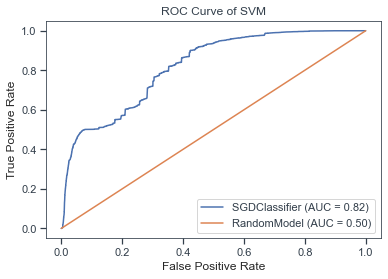

In [175]:
#Plotting ROC curve

plot_roc_curve(
    svc_model,
    X_test_distance,
    y_test
)
plt.title('ROC Curve of SVM')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
plt.legend()
plt.show()

In [176]:
svc_table = PrettyTable()
svc_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  'Log-loss'
                 ]

svc_preds = svc_model.predict(X_test_distance)

svc_table.add_row([
    'SVM',
    accuracy_score(y_true = y_test, y_pred = svc_preds),
    f1_score(y_true = y_test, y_pred = svc_preds),
    precision_score(y_true = y_test, y_pred = svc_preds),
    recall_score(y_true = y_test, y_pred = svc_preds),
    log_loss(y_true = y_test, y_pred = svc_preds)
])

print(svc_table)

+------------+--------------------+--------------------+---------------------+--------------------+--------------------+
| Model Name |      Accuracy      |      F1-Score      |      Precision      |       Recall       |      Log-loss      |
+------------+--------------------+--------------------+---------------------+--------------------+--------------------+
|    SVM     | 0.9139061267871225 | 0.1418856576564262 | 0.08263837748542086 | 0.5012676566461427 | 2.9736402138553144 |
+------------+--------------------+--------------------+---------------------+--------------------+--------------------+


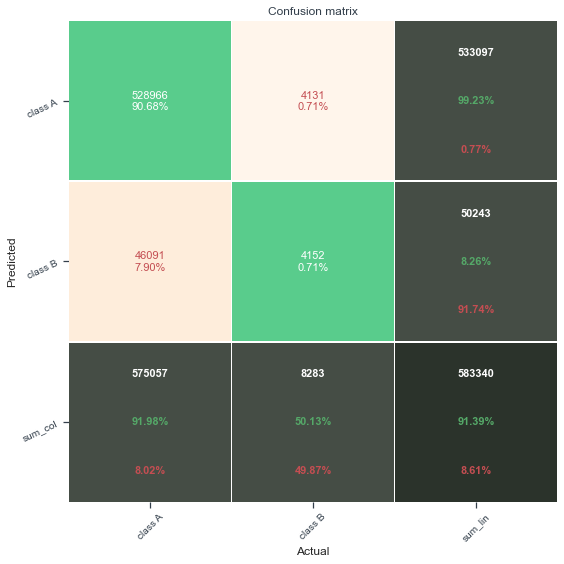

In [177]:
#displaying confusion matrix

conf_matrix(
    y_test = y_test,
    predictions = svc_model.predict(X_test_distance)
)

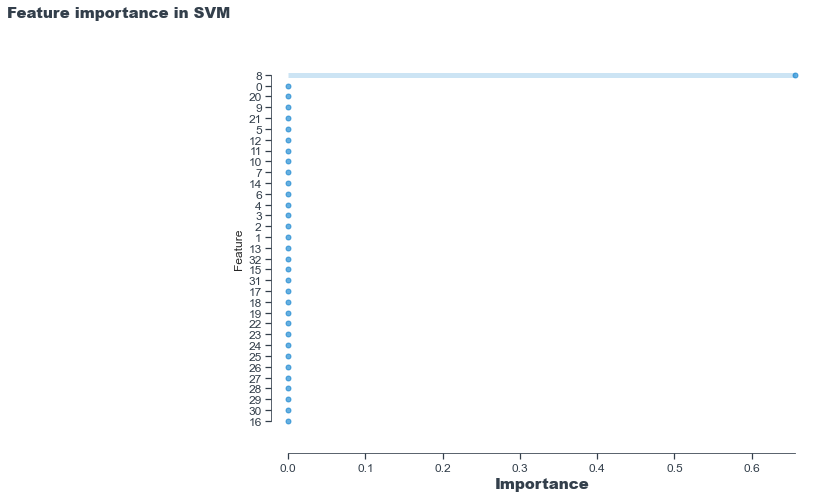

In [178]:
pretty_importances_plot(
    np.abs(svc_model.coef_[0]), 
    [i for i in range(X_train_distance.shape[1])],
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in SVM'
)

## 5.3 Modelling - Tree based models 
* Tree based models are a family of classifiers which form a tree with each attribute at one level and which perform series of condition checking with one attribute at a time

In [179]:
#taking a sub-df of all the positive class datapoints for comparison

temp_df = pd.DataFrame(X_train_tree)

positive_df_tree = pd.DataFrame([], columns = temp_df.columns)
negative_df_tree = pd.DataFrame([], columns = temp_df.columns)
index = 0

for index_df, row in tqdm(temp_df.iterrows(), total=temp_df.shape[0]):
    if y_train[index] == 0:
        if np.random.uniform(0, 1) < 0.015:
            #picking negative class with a probability of 1.5%
            negative_df_tree = negative_df_tree.append(row, ignore_index=True)
            index += 1
        else:
            index += 1

    elif y_train[index] == 1:
        #picking all positive data-points
        positive_df_tree = positive_df_tree.append(row, ignore_index=True)
        index += 1 

In [180]:
combined_X_tree = positive_df_tree.append(negative_df_tree)
combined_y_tree = np.append([1] * positive_df_tree.shape[0], [0] * negative_df_tree.shape[0])

In [181]:
combined_X_tree.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2012.0,54.0,0.0,1.000000,1.0,0.0,2.0,155000000.0,0.038124,3.0,1.0,1.0,4.119435,0.584169,0.000000,-0.895193,9.999995e-07,0.5,2.0,2.0
1,2016.0,219.0,144.0,0.251953,1754.0,0.0,2.0,84620000.0,0.000000,5.0,0.0,3.0,4.112403,0.584169,-1.218924,-0.835022,7.469654e+00,0.5,1.0,0.0
2,2013.0,286.0,110.0,0.845155,28.0,0.0,2.0,37905000.0,0.038124,6.0,1.0,4.0,4.101345,0.584169,-0.165682,-0.606411,3.332205e+00,0.5,1.0,0.0
3,2016.0,278.0,144.0,0.049580,1724.0,0.0,2.0,119940000.0,0.000000,1.0,1.0,4.0,4.116580,0.584169,-2.313147,-0.835022,7.452402e+00,0.5,1.0,1.0
4,2016.0,110.0,0.0,0.500000,1.0,0.0,2.0,125000000.0,0.000000,1.0,0.0,2.0,4.117052,0.584169,-0.651137,-0.895193,9.999995e-07,0.5,2.0,2.0


In [182]:
combined_y_tree

array([1, 1, 1, ..., 0, 0, 0])

### 5.3.1 Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest_hyperparam = RandomizedSearchCV(
    estimator = RandomForestClassifier(
        n_jobs = -1,
        random_state = 42,
        class_weight = 'balanced'
    ),
    param_distributions = {
        'n_estimators' : [100, 500, 1000],
    },
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1,
    random_state = 42,
    return_train_score = True,
    n_iter = 25
).fit(combined_X_train, combined_y_train)

In [ ]:
random_forest_hyperparam.best_params_

In [ ]:
rf_clf = RandomForestClassifier(
    n_estimators = 500,
    class_weight = 'balanced',
    random_state = 42,
    n_jobs = -1
).fit(X_train_tree, y_train)

In [184]:
rf_preds = rf_clf.predict(X_test_tree)

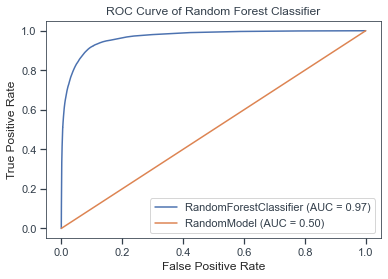

In [185]:
#Plotting ROC curve

plot_roc_curve(
    rf_clf,
    X_test_tree,
    y_test
)
plt.title('ROC Curve of Random Forest Classifier')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
plt.legend()
plt.show()

In [186]:
rf_table = PrettyTable()
rf_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  'Log-loss'
                 ]

rf_preds = rf_clf.predict(X_test_tree)

rf_table.add_row([
    'Random Forest',
    accuracy_score(y_true = y_test, y_pred = rf_preds),
    f1_score(y_true = y_test, y_pred = rf_preds),
    precision_score(y_true = y_test, y_pred = rf_preds),
    recall_score(y_true = y_test, y_pred = rf_preds),
    log_loss(y_true = y_test, y_pred = rf_preds)
])

print(rf_table)

+---------------+--------------------+---------------------+--------------------+----------------------+--------------------+
|   Model Name  |      Accuracy      |       F1-Score      |     Precision      |        Recall        |      Log-loss      |
+---------------+--------------------+---------------------+--------------------+----------------------+--------------------+
| Random Forest | 0.9858641615524394 | 0.01150803164708703 | 0.8135593220338984 | 0.005795001810938066 | 0.4882345783728284 |
+---------------+--------------------+---------------------+--------------------+----------------------+--------------------+


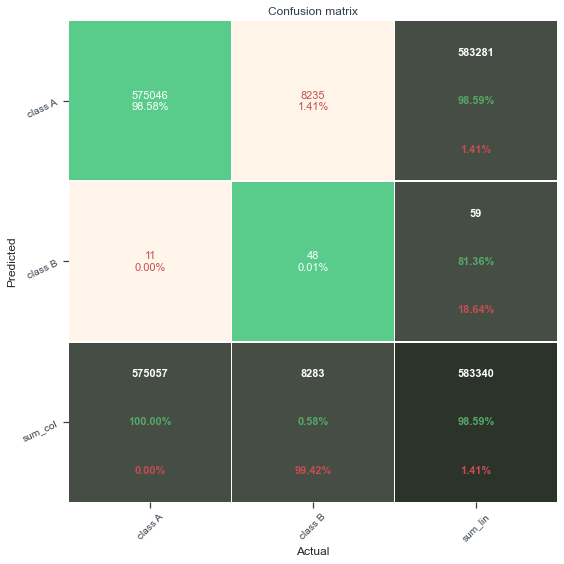

In [187]:
#displaying confusion matrix

conf_matrix(
    y_test = y_test,
    predictions = rf_preds
)

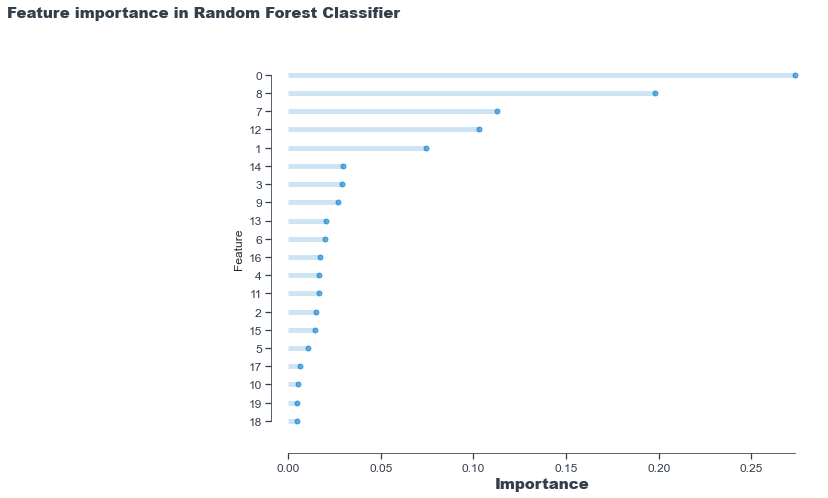

In [188]:
#displaying feature importances

pretty_importances_plot(
    rf_clf.feature_importances_, 
    [i for i in range(X_train_tree.shape[1])],
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in Random Forest Classifier'
)

### 5.3.2 Gradient Boosted Decision Trees

In [ ]:
from xgboost import XGBClassifier
from collections import Counter

#we use counter to get an esimator as to how much 
#weight should be given to positive class

#why? because only 1.5% of our data-set contains positive datapoints

counter = Counter(y_train)
estimate = counter[0] / counter[1]

gbdt_clf = XGBClassifier(
    n_estimators = 500,
    max_depth = 2,
    verbosity = 1,
    n_jobs = -1,
    random_state = 42,
    scale_pos_weight = estimate
).fit(X_train_tree, y_train, verbose=1)

In [ ]:
#hyper-paramter turning

gbdt_hyperparam = RandomizedSearchCV(
    estimator = XGBClassifier(
            max_depth = 2,
            verbosity = 1,
            n_jobs = -1,
            random_state = 42,
            scale_pos_weight = estimate
    ),
    pararm_distributions = [100, 500, 1000, 2000],
    n_jobs = -1,
    verbose = 3,
    random_state = 42
)

In [189]:
gbdt_pred = gbdt_clf.predict(X_test_tree)

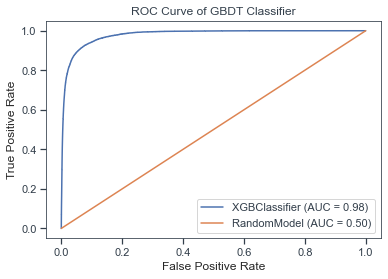

In [190]:
#Plotting ROC curve

plot_roc_curve(
    gbdt_clf,
    X_test_tree,
    y_test
)
plt.title('ROC Curve of GBDT Classifier')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='RandomModel (AUC = 0.50)')
plt.legend()
plt.show()

In [191]:
gbdt_table = PrettyTable()
gbdt_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  'Log-loss'
                 ]

gbdt_pred = gbdt_clf.predict(X_test_tree)

gbdt_table.add_row([
    'GBDT',
    accuracy_score(y_true = y_test, y_pred = gbdt_pred),
    f1_score(y_true = y_test, y_pred = gbdt_pred),
    precision_score(y_true = y_test, y_pred = gbdt_pred),
    recall_score(y_true = y_test, y_pred = gbdt_pred),
    log_loss(y_true = y_test, y_pred = gbdt_pred)
])

print(gbdt_table)

+------------+--------------------+--------------------+---------------------+--------------------+--------------------+
| Model Name |      Accuracy      |      F1-Score      |      Precision      |       Recall       |      Log-loss      |
+------------+--------------------+--------------------+---------------------+--------------------+--------------------+
|    GBDT    | 0.9222151746837179 | 0.2527789213668176 | 0.14635216048205638 | 0.9265966437281178 | 2.6866540516632327 |
+------------+--------------------+--------------------+---------------------+--------------------+--------------------+


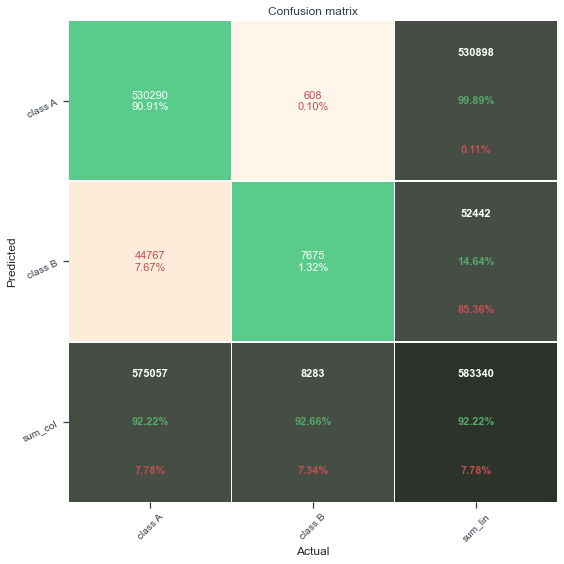

In [192]:
#displaying confusion matrix

conf_matrix(
    y_test = y_test,
    predictions = gbdt_pred
)

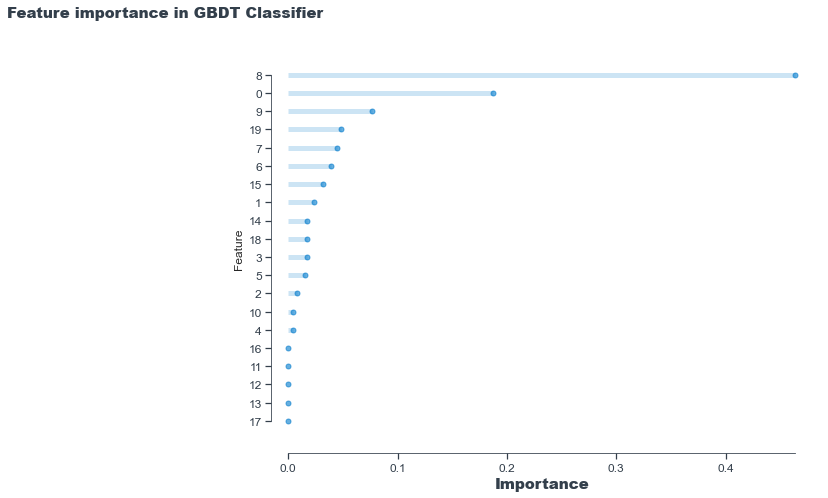

In [193]:
#feature importances

pretty_importances_plot(
    gbdt_clf.feature_importances_, 
    [i for i in range(X_train_tree.shape[1])],
    xlabel = 'Importance',
    ylabel = 'Feature',
    horizontal_label = 'Feature importance in GBDT Classifier'
)

## 5.4 Modelling - Stacking Classifier
* Stacked generalization consists in stacking the output of individual estimator and use a classifier to compute the final prediction. Stacking allows to use the strength of each individual estimator by using their output as input of a final estimator.

In [194]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

stacking_clf_distance = StackingClassifier(
    estimators = [
        ('lr', lr_full),
        ('svc', svc_model)
    ],
    n_jobs = -1,
    verbose = 3,
).fit(X_train_distance, y_train)

In [195]:
class StackingClassifierTree():
    '''
    Custom implementation of Stacking classifier as a little
    more flexiblity with the code is needed.
    '''
    
    def __init__(self, rf_clf, gbdt_clf, C=1.0):
        #get the hyper-param and initialize the model
        self.C = C
        self.rf_clf = rf_clf
        self.gbdt_clf = gbdt_clf
        self.stacking_clf_tree = LogisticRegression(
            C = self.C,
            n_jobs = -1,
            class_weight = 'balanced',
            random_state = 42
            )
        
    def fit(self, X, y):
        #fit the model
        self.stacking_clf_tree.fit(
            pd.DataFrame([
                self.rf_clf.predict(X),
                self.gbdt_clf.predict(X)
            ]).T,
            y_train
            )
        
    def predict(self, x):
        #return predictions
        rf_preds = self.rf_clf.predict(x)
        gbdt_preds = self.gbdt_clf.predict(x)
        
        return self.stacking_clf_tree.predict(
                pd.DataFrame([
                    rf_preds,
                    gbdt_preds
                ]).T
            )
        
stack_clf_tree = StackingClassifierTree(rf_clf, gbdt_clf, C=1)

In [196]:
stack_clf_tree.fit(X_train_tree, y_train)

In [197]:
stack_tree_preds = stack_clf_tree.predict(X_test_tree)

In [198]:
print('The accuracy using just tree-stacked classifier is {}'.format(
    accuracy_score(
    y_true = y_test,
    y_pred = stack_tree_preds
)
))

The accuracy using just tree-stacked classifier is 0.9858641615524394


In [199]:
class FinalStackedClassifier():
    '''
    Custom implementation of the meta classifier.
    This class stacks both tree-based and distance-based models
    to give the best possibile predictions.
    '''
    def __init__(self, loss):
        #get loss and initialize classifier
        
        self.loss = loss
        self.final_stacked_clf = SGDClassifier(
                        loss = self.loss,
                        penalty = 'elasticnet',
                        n_jobs = -1,
                        random_state = 42,
                        class_weight = 'balanced'
                    )
        
    def fit(self, X_distance, X_tree, y):
        #fit the classifier
        
        self.distance_pred = stacking_clf_distance.predict(X_distance)
        self.tree_pred = stack_clf_tree.predict(X_tree)
        
        self.final_stacked_clf.fit(
            pd.DataFrame([
                self.distance_pred,
                self.tree_pred
            ]).T,
            y
        )
        return True
        
    def predict(self, X_distance, X_tree):
        #return predictions
        
        self.distance_pred = stacking_clf_distance.predict(X_distance)
        self.tree_pred = stack_clf_tree.predict(X_tree)
        
        return self.final_stacked_clf.predict(
                pd.DataFrame([
                    self.distance_pred,
                    self.tree_pred
                ]).T
            )

In [202]:
#Create object and get predictions from meta classifier

final_stacked_clf = FinalStackedClassifier(loss='log')
final_stacked_clf.fit(X_train_distance, X_train_tree, y_train)
final_stacked_preds = final_stacked_clf.predict(X_test_distance, X_test_tree)

In [203]:
#displaying table

stacking_table = PrettyTable()
stacking_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  'Log-loss'
                 ]

final_stacked_preds = final_stacked_clf.predict(X_test_distance)

stacking_table.add_row([
    'StackingClassifier',
    accuracy_score(y_true = y_test, y_pred = final_stacked_preds),
    f1_score(y_true = y_test, y_pred = final_stacked_preds),
    precision_score(y_true = y_test, y_pred = final_stacked_preds),
    recall_score(y_true = y_test, y_pred = final_stacked_preds),
    log_loss(y_true = y_test, y_pred = final_stacked_preds)
])

print(stacking_table)

+--------------------+--------------------+---------------------+--------------------+----------------------+--------------------+
|     Model Name     |      Accuracy      |       F1-Score      |     Precision      |        Recall        |      Log-loss      |
+--------------------+--------------------+---------------------+--------------------+----------------------+--------------------+
| StackingClassifier | 0.9858641615524394 | 0.01150803164708703 | 0.8135593220338984 | 0.005795001810938066 | 0.4882345783728284 |
+--------------------+--------------------+---------------------+--------------------+----------------------+--------------------+


## 5.5 Final results

In [204]:
final_table = PrettyTable()
final_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  'Log-loss'
                 ]

final_table.add_row([
    'Logistic Regression',
    accuracy_score(y_true = y_test, y_pred = lr_preds),
    f1_score(y_true = y_test, y_pred = lr_preds),
    precision_score(y_true = y_test, y_pred = lr_preds),
    recall_score(y_true = y_test, y_pred = lr_preds),
    log_loss(y_true = y_test, y_pred = lr_preds)
])

final_table.add_row([
    'SVM',
    accuracy_score(y_true = y_test, y_pred = svc_preds),
    f1_score(y_true = y_test, y_pred = svc_preds),
    precision_score(y_true = y_test, y_pred = svc_preds),
    recall_score(y_true = y_test, y_pred = svc_preds),
    log_loss(y_true = y_test, y_pred = svc_preds)
])

final_table.add_row([
    'Random Forest',
    accuracy_score(y_true = y_test, y_pred = rf_preds),
    f1_score(y_true = y_test, y_pred = rf_preds),
    precision_score(y_true = y_test, y_pred = rf_preds),
    recall_score(y_true = y_test, y_pred = rf_preds),
    log_loss(y_true = y_test, y_pred = rf_preds)
])

final_table.add_row([
    'GBDT',
    accuracy_score(y_true = y_test, y_pred = gbdt_pred),
    f1_score(y_true = y_test, y_pred = gbdt_pred),
    precision_score(y_true = y_test, y_pred = gbdt_pred),
    recall_score(y_true = y_test, y_pred = gbdt_pred),
    log_loss(y_true = y_test, y_pred = gbdt_pred)
])

final_table.add_row([
    'StackingClassifier',
    accuracy_score(y_true = y_test, y_pred = final_stacked_preds),
    f1_score(y_true = y_test, y_pred = final_stacked_preds),
    precision_score(y_true = y_test, y_pred = final_stacked_preds),
    recall_score(y_true = y_test, y_pred = final_stacked_preds),
    log_loss(y_true = y_test, y_pred = final_stacked_preds)
])

print(final_table)

+---------------------+--------------------+---------------------+----------------------+----------------------+--------------------+
|      Model Name     |      Accuracy      |       F1-Score      |      Precision       |        Recall        |      Log-loss      |
+---------------------+--------------------+---------------------+----------------------+----------------------+--------------------+
| Logistic Regression | 0.8633781328213392 |  0.0981951909476662 | 0.054175198521700045 |  0.5238440178679222  | 4.718855957502188  |
|         SVM         | 0.9139061267871225 |  0.1418856576564262 | 0.08263837748542086  |  0.5012676566461427  | 2.9736402138553144 |
|    Random Forest    | 0.9858641615524394 | 0.01150803164708703 |  0.8135593220338984  | 0.005795001810938066 | 0.4882345783728284 |
|         GBDT        | 0.9222151746837179 |  0.2527789213668176 | 0.14635216048205638  |  0.9265966437281178  | 2.6866540516632327 |
|  StackingClassifier | 0.9858641615524394 | 0.011508031647087

* Since our most important concern is to predict ransomware transactions and mis-classify positive class data-points as less as possible, we go with the model that gives us the best Recall.
* Hence, we choose GBDT.

## 5.6 Best model: GBDT

In [ ]:
from xgboost import XGBClassifier
from collections import Counter

counter = Counter(y_train)
estimate = counter[0] / counter[1]

gbdt_clf = XGBClassifier(
    n_estimators = 2000,
    max_depth = 2,
    verbosity = 1,
    n_jobs = -1,
    random_state = 42,
    scale_pos_weight = estimate
).fit(X_train_tree, y_train, verbose=1)

In [206]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, log_loss


gbdt_table = PrettyTable()

gbdt_pred = gbdt_clf.predict(X_test_tree)

gbdt_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  'Log-loss'
                 ]

gbdt_table.add_row([
    'GBDT',
    accuracy_score(y_true = y_test, y_pred = gbdt_pred),
    f1_score(y_true = y_test, y_pred = gbdt_pred),
    precision_score(y_true = y_test, y_pred = gbdt_pred),
    recall_score(y_true = y_test, y_pred = gbdt_pred),
    log_loss(y_true = y_test, y_pred = gbdt_pred)
])

print(gbdt_table)

+------------+-------------------+---------------------+---------------------+--------------------+-------------------+
| Model Name |      Accuracy     |       F1-Score      |      Precision      |       Recall       |      Log-loss     |
+------------+-------------------+---------------------+---------------------+--------------------+-------------------+
|    GBDT    | 0.935205883361333 | 0.28884833204763966 | 0.17108723755182098 | 0.9267173729325123 | 2.237960483469106 |
+------------+-------------------+---------------------+---------------------+--------------------+-------------------+


# 6.0 Comparison with stock data
* To understand if our data-cleaning and feature engineering has helped get better performance from our models, we compare the results with our original unprocessed data.

In [ ]:
#Stock data
#X_train is not processed.

counter = Counter(y_train)
estimate = counter[0] / counter[1]

gbdt_dirty = XGBClassifier(
    n_estimators = 2000,
    max_depth = 2,
    verbosity = 1,
    n_jobs = 6,
    random_state = 42,
    scale_pos_weight = estimate
).fit(X_train_stock.drop(['address'], axis=1), y_train, verbose=1)

gbdt_dirty_preds = gbdt_dirty.predict(X_test_stock.drop(['address'], axis=1))

In [207]:
#printing table

dirty_table = PrettyTable()

dirty_table.field_names = ['Model Name',
                  'Accuracy',
                  'F1-Score',
                  'Precision',
                  'Recall',
                  'Log-loss'
                 ]

dirty_table.add_row([
    'GBDT dirty',
    accuracy_score(y_true = y_test, y_pred = gbdt_dirty_preds),
    f1_score(y_true = y_test, y_pred = gbdt_dirty_preds),
    precision_score(y_true = y_test, y_pred = gbdt_dirty_preds),
    recall_score(y_true = y_test, y_pred = gbdt_dirty_preds),
    log_loss(y_true = y_test, y_pred = gbdt_dirty_preds)
])

gbdt_pred = gbdt_clf.predict(X_test_tree)

dirty_table.add_row([
    'GBDT clean',
    accuracy_score(y_true = y_test, y_pred = gbdt_pred),
    f1_score(y_true = y_test, y_pred = gbdt_pred),
    precision_score(y_true = y_test, y_pred = gbdt_pred),
    recall_score(y_true = y_test, y_pred = gbdt_pred),
    log_loss(y_true = y_test, y_pred = gbdt_pred)
])

print(dirty_table)

+------------+--------------------+---------------------+---------------------+--------------------+-------------------+
| Model Name |      Accuracy      |       F1-Score      |      Precision      |       Recall       |      Log-loss     |
+------------+--------------------+---------------------+---------------------+--------------------+-------------------+
| GBDT dirty | 0.8594096067473515 | 0.15233074935400515 | 0.08329659647100049 | 0.8896535071833876 | 4.855931318702317 |
| GBDT clean | 0.935205883361333  | 0.28884833204763966 | 0.17108723755182098 | 0.9267173729325123 | 2.237960483469106 |
+------------+--------------------+---------------------+---------------------+--------------------+-------------------+


* Our engineered features and cleansed data have indeed increased the performace of our model
* We see a substantial increase all the metrics in our models.

# 7.0 Conclusion and remarks

- We have gotten a data-set with extremely skewed features and normalized it by applying various transformations. We cleaned the data and performed uni-variate and multi-variate analysis on it to figure out which features play the biggest role in predicting the dependent feature.
- We decide our KPI (Key Performance Indicator) to be Recall.
- We have applied various algorithms on the data right from linear models, to tree-based models and even tried stacking these models to see if we have any improvement.
- We find out that GBDT perform the best on our data and was able to achieve the highest recall among all other models.

# 8.0 References

1. Goldsmith, D., Grauer, K., & Shmalo, Y. (2020). Analyzing hack subnetworks in the bitcoin transaction graph. Applied Network Science, 5, 1-20. [link](https://appliednetsci.springeropen.com/articles/10.1007/s41109-020-00261-7)
2. Rivera-Castro, R., Pilyugina, P., & Burnaev, E. (2019, November). Topological Data Analysis for Portfolio Management of Cryptocurrencies. In 2019 International Conference on Data Mining Workshops (ICDMW) (pp. 238-243), IEEE [link](https://arxiv.org/pdf/1906.07852.pdf)